In [44]:
import re, pytesseract
import spacy, csv, mimetypes
nlp = spacy.load("en_core_web_sm")

In [45]:
from collections import defaultdict


In [46]:
%pip install "camelot-py[cv]"

import openai
import camelot        # pip install "camelot-py[cv]"
import pdfplumber     # you already use this elsewhere



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
import os
from dotenv import load_dotenv
load_dotenv()                           # expects .env in the repo root

OPENAI_API_KEY  = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV     = os.getenv("PINECONE_ENV")  # e.g. "gcp-starter"

In [48]:
import os, base64
from pathlib import Path
from tqdm import tqdm

import fitz                         # PyMuPDF 2.0+
import tabula                       # needs Java;  pip install tabula-py jpype1
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [50]:
from pathlib import Path
import os, base64, json, fitz, pdfplumber
from tqdm import tqdm
import tabula
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ---------- CONFIG ----------
PDF_PATH  = Path("doc2.pdf")
BASE_DIR  = Path("data")
DIAGRAM_THRESHOLD = 0.60   # % of page area to be considered full-page diagram
LOGO_THRESHOLD    = 0.10   # % of page area under which we skip as logo/ornament
TEXT_EMPTY_LIMIT   = 100   # page is “empty” if ≤ 100 chars
NEIGHBOR_MIN_CHARS = 200   # char count to decide page is "mostly image"
PIXMAP_ZOOM       = 3      # render factor for full page images
# ----------------------------


In [51]:
# ── page-number helpers ───────────────────────────────────────────────
def pdf_page_no(zero_based: int) -> int:
    """Human page number shown on the PDF (starts at 1)."""
    return zero_based + 1

def page_no_str(zero_based: int) -> str:
    """Formatted page label you can embed in filenames, e.g. 0 → 'p001'."""
    return f"p{zero_based + 1:03d}"
# ---------------------------------------------------------------------


In [52]:
# 1 · utils ------------------------------------------------------
def ensure_dirs():
    for sub in ["images", "text", "tables", "page_images"]:
        (BASE_DIR / sub).mkdir(parents=True, exist_ok=True)

def save_txt(fname: Path, txt: str):
    fname.write_text(txt, encoding="utf-8")

def save_pixmap(pix: fitz.Pixmap, fname: Path):
    if pix.alpha or pix.colorspace.n > 3:
        pix = fitz.Pixmap(fitz.csRGB, pix)
    pix.save(fname)


In [53]:
from io import BytesIO
from PIL import Image
import imagehash

# Global trackers
HASH_COUNTS = {}
SKIP_HASHES = set()

def pixmap_to_pil(pix: fitz.Pixmap) -> Image.Image:
    """Convert PyMuPDF pixmap to PIL Image, with fallback for broken samples"""
    try:
        # Convert via bytes safely
        mode = "RGB" if pix.n < 5 else "RGBA"
        img_bytes = pix.tobytes(output="ppm")  # robust fallback
        return Image.open(BytesIO(img_bytes)).convert(mode)
    except Exception as e:
        print(f"[warn] pixmap_to_pil failed: {e}")
        return None


def should_skip_pil_image(pil_img: Image.Image, min_repeat: int = 3) -> bool:
    """Decide whether to skip an image based on perceptual hash frequency"""
    img_hash = str(imagehash.phash(pil_img))
    if img_hash in SKIP_HASHES:
        return True
    HASH_COUNTS[img_hash] = HASH_COUNTS.get(img_hash, 0) + 1
    if HASH_COUNTS[img_hash] >= min_repeat:
        SKIP_HASHES.add(img_hash)
        return True
    return False


In [11]:
WARNING_TAGS = ("WARNING", "CAUTION", "DANGER", "NOTE", "STEP")
def tag_special_chunks(txt:str)->str:
    for tag in WARNING_TAGS:
        if txt.upper().startswith(tag):
            return f"[{tag}] {txt}"
    return txt

In [54]:
# from pathlib import Path
import base64, mimetypes, uuid, os, time
# from tqdm import tqdm

import openai                     # v1.14+
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone, ServerlessSpec

# openai.api_key      = os.getenv("OPENAI_API_KEY")
# PINECONE_API_KEY    = os.getenv("PINECONE_API_KEY")

# ── embedding & chat models (adjust if your account differs) ────────────
EMBED_MODEL = "text-embedding-3-large"    # 1536-D, GPT-4 family
CHAT_MODEL  = "gpt-4o-mini"               # vision-capable

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")  # keep this

pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "multimodal-manual"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # or embeddings.embedding_dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)


In [55]:
def img_to_data_uri(path: Path) -> str:
    mime, _ = mimetypes.guess_type(path)
    b64 = base64.b64encode(path.read_bytes()).decode()
    return f"data:{mime or 'image/png'};base64,{b64}"

Table Extraction begins


In [56]:
# ── put this near the other helpers, ABOVE extract_pdf ──────────────────
import camelot
import warnings
from pathlib import Path

def harvest_tables(pdf_path: Path, page_no: int, **camelot_kw):
    """
    Return a list of Camelot tables (can be empty) extracted from *one* page.
    Silences the noisy 'No tables found' warning and handles None-returns.
    """
    results = []

    # ① try lattice first (good for ruled tables)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        try:
            latt = camelot.read_pdf(
                str(pdf_path),
                pages=str(page_no),
                flavor="lattice",
                **camelot_kw
            )
            results.extend(t for t in latt)     # t is already a Table object
        except Exception as e:
            print(f"[warn] Camelot lattice failed p{page_no}: {e}")

    # ② fallback to stream (good for whitespace-separated tables)
    if not results:                       # only try if lattice found nothing
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            try:
                stre = camelot.read_pdf(
                    str(pdf_path),
                    pages=str(page_no),
                    flavor="stream",
                    **camelot_kw
                )
                results.extend(t for t in stre)
            except Exception as e:
                print(f"[warn] Camelot stream failed p{page_no}: {e}")

    return results


In [57]:
def is_bad_table(rows, min_cols=2, min_rows=3, empty_thresh=0.3):
    if len(rows) < min_rows:
        return True
    num_cols = max(len(r) for r in rows)
    if num_cols < min_cols:
        return True
    total = sum(len(r) for r in rows)
    empty = sum(1 for r in rows for c in r if not c.strip())
    return (empty / total) > empty_thresh


In [58]:
def looks_like_table(text: str, min_rows=3, min_cols=2, col_variance=1):
    lines = [line.strip() for line in text.strip().splitlines() if len(line.strip()) > 10]
    
    if len(lines) < min_rows:
        return False

    col_counts = []

    for line in lines:
        if "|" in line:
            cols = line.split("|")
        elif "\t" in line:
            cols = line.split("\t")
        else:
            cols = re.split(r"\s{2,}", line)

        num_cols = len([c for c in cols if c.strip()])
        if num_cols >= min_cols:
            col_counts.append(num_cols)

    if len(col_counts) < min_rows:
        return False

    # Check for consistent column count (tolerance ±1)
    most_common = max(set(col_counts), key=col_counts.count)
    consistent_rows = sum(abs(nc - most_common) <= col_variance for nc in col_counts)

    return consistent_rows >= min_rows


In [59]:
from PIL import Image

def classify_and_format_tables(ocr_items, model="gpt-4o", max_tokens=1000):
    formatted_items = []
    for item in ocr_items:
        table_text = item["text"]
        path = Path(item["path"])

        classify_prompt = (
            "Does the following text represent a structured table with rows and columns "
            "(e.g., part numbers and descriptions)? Answer only 'Yes' or 'No'.\n\n"
            + table_text
        )

        try:
            classification = openai.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": classify_prompt}],
                temperature=0,
                max_tokens=10
            ).choices[0].message.content.strip().lower()

            if classification == "yes":
                format_prompt = (
                    "Please format the following OCR-extracted text into a structured table "
                    "in markdown format. Infer column headers if not present. "
                    "Fix common OCR issues like broken part numbers or header noise. Part no. do not start with numbers. Ignore numbers in the beginning of part no. as there might be improper OCR extraction."
                    "If possible try to give a name for the table based on any relevant information available, which might be useful while retrieving relevant chunks\n\n"
                    + table_text
                )

                formatted = openai.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": format_prompt}],
                    temperature=0.2,
                    max_tokens=max_tokens
                ).choices[0].message.content.strip()

                formatted_path = path.with_suffix(".formatted.md")
                formatted_path.write_text(formatted, encoding="utf-8")

                formatted_items.append({
                    "page": item["page"],
                    "original_path": str(path),
                    "formatted_path": str(formatted_path),
                    "formatted_text": formatted
                })

                # ✅ delete original noisy OCR .txt
                if path.exists():
                    path.unlink()

            else:
                print(f"❌ Not a table (deleted): {path.name}")
                if path.exists():
                    path.unlink()

        except Exception as e:
            print(f"[!] Error processing table on page {item['page']}: {e}")
            continue

    return formatted_items


In [60]:
def extract_headings(words):
    """Heuristic: return candidate headings by largest font sizes (based on height)."""
    if not words: 
        return []
    # Estimate font size from height
    for w in words:
        w["size"] = round(w["bottom"] - w["top"], 2)

    # Pick largest 2-3 sizes as likely headings
    sizes = sorted({w["size"] for w in words}, reverse=True)[:3]
    headings = [w for w in words if w["size"] in sizes and w["text"].strip()]

    # Group into lines
    result = []
    line = ""
    y_prev = None
    for w in headings:
        if y_prev is None or abs(w["top"] - y_prev) < 2:
            line += " " + w["text"]
        else:
            result.append(line.strip())
            line = w["text"]
        y_prev = w["top"]
    if line.strip(): 
        result.append(line.strip())
    return result


In [61]:
############ New Captioning Logic #############

from pathlib import Path          # <-- add (if not already imported)
import hashlib                    # <-- add
import json

caption_cache_file = Path("captions_cache.json")      # make it a Path
try:
    caption_cache: dict[str, str] = json.loads(caption_cache_file.read_text())
except FileNotFoundError:
    caption_cache = {}
except json.JSONDecodeError:          
    print("[warn] captions cache is broken – recreating it")
    caption_cache = {}

def _image_hash(path: Path) -> str:
    """SHA-1 of the *bytes* – fast and collision-safe for our use-case."""
    return hashlib.sha1(path.read_bytes()).hexdigest()

def caption_image_cached(path: Path, **kwargs) -> str:
    """
    Same API as before, but now:
      • key = hash(image_bytes)
      • writes back to captions_cache.json automatically
    """
    key = _image_hash(path)

    # 1) already cached?  → return without hitting the model
    if key in caption_cache:
        return caption_cache[key]

    # 2) otherwise call GPT (your original helper)
    caption = caption_image(path, **kwargs)
    print("Caption:", caption)

    # 3) persist
    caption_cache[key] = caption
    caption_cache_file.write_text(
        json.dumps(caption_cache, indent=2, ensure_ascii=False)
    )
    return caption

In [62]:
#################### image extraction using GPT Begins #########################
def load_text_chunks(text_dir: Path) -> dict:
    pages = defaultdict(list)
    for file in text_dir.glob("doc2_p*_txt*.txt"):
        match = re.search(r"doc2_p(\d+)_txt\d+.txt", file.name)
        if match:
            page = int(match.group(1))
            pages[page].append(file.read_text().strip())
    return pages

def build_context_for_page(pages: dict, page: int, max_back: int = 3) -> str:
    context = []
    # 1. Include current page text first (most important)
    context.extend(pages.get(page, []))

    # 2. Then include up to `max_back` previous pages (heading/snippet support)
    for p in reversed(range(max(0, page - max_back), page)):
        context.extend(pages.get(p, []))

    return "\n\n".join(context)


def build_metadata_prompt(image_filename: str, context: str) -> str:
    return f"""
You are analyzing a page from a machine user manual that includes an illustration named {image_filename}.

From the given context, extract the following metadata:

1. Section header: The most recent section heading (e.g., "2.1 Technical Warnings").
2. Figure title: The full label like "Figure 5 – Speed Adjustment Panel", if present.
3. Snippet: A 200–400 character text snippet surrounding the figure title.
4. Purpose: What the figure illustrates and why it matters in the manual (one sentence).

Respond in the following structured format:

Section header: ...
Figure title: ...
Snippet: ...
Purpose: ...
"""

def caption_with_gpt_vision(image_path: Path, context: str) -> dict:
    data_uri = img_to_data_uri(image_path)
    prompt = build_metadata_prompt(image_path.name, context)

    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": data_uri}},
                {"type": "text", "text": context[:10000]}
            ]
        }],
        max_tokens=300
    )

    raw = response.choices[0].message.content.strip()
    metadata = {}

    # Parse GPT response into structured dict
    for line in raw.splitlines():
        if ":" in line:
            k, v = line.split(":", 1)
            metadata[k.strip()] = v.strip()

    return metadata


pages = load_text_chunks(Path("data/text"))

metadata_cache_file = Path("image_metadata_cache.json")
if metadata_cache_file.exists():
    metadata_cache = json.loads(metadata_cache_file.read_text(encoding="utf-8"))
else:
    metadata_cache = {}

In [63]:
def extract_pdf_pass1(pdf_path: Path) -> list[dict]:
    ensure_dirs()
    splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200)
    items = []
    doc = fitz.open(pdf_path)
    HASH_COUNTS.clear()
    SKIP_HASHES.clear()

    for page_idx in tqdm(range(len(doc)), desc="Pass 1: Extracting text/tables/images"):
        page = doc[page_idx]
        raw_text = page.get_text("text", sort=True).strip()
        caption_lines = []
        current_h = ""

        try:
            with pdfplumber.open(pdf_path) as plumber_pdf:
                plumber_page = plumber_pdf.pages[page_idx]
                pl_words = plumber_page.extract_words()
                headings = extract_headings(pl_words)
                current_h = headings[0] if headings else ""
        except Exception as e:
            print(f"[warn] Heading extraction failed on page {page_idx}: {e}")

        # OCR fallback
        if len(raw_text) < 20:
            ocr_img = page.get_pixmap(matrix=fitz.Matrix(2, 2))
            ocr_txt = pytesseract.image_to_string(Image.open(BytesIO(ocr_img.tobytes()))).strip()
            if len(ocr_txt) > 20:
                raw_text = ocr_txt

        # Save text chunks
        for i, chunk in enumerate(splitter.split_text(raw_text)):
            page_lbl = page_no_str(page_idx)
            f = BASE_DIR / "text" / f"{pdf_path.stem}_{page_lbl}_txt{i:02d}.txt"
            save_txt(f, chunk)
            items.append({
                "page": pdf_page_no(page_idx),
                "page0": page_idx,
                "type": "text",
                "text": chunk,
                "section": current_h,
                "path": str(f)
            })

        # Table extraction
        tables = harvest_tables(pdf_path, page_idx + 1)
        for t_idx, table in enumerate(tables):
            if hasattr(table, "df"):
                rows = table.df.values.tolist()
            elif hasattr(table, "values"):
                rows = table.values.tolist()
            else:
                rows = table

            cleaned = []
            for row in rows:
                row = [str(c).strip().replace("\n", " ") if c else "" for c in row]
                if any(cell for cell in row):
                    cleaned.append(row)

            reconstructed = []
            current_row = None
            for row in cleaned:
                if row[0].strip():
                    if current_row:
                        reconstructed.append(current_row)
                    current_row = row
                else:
                    if current_row:
                        for i in range(len(row)):
                            if row[i].strip():
                                current_row[i] += " " + row[i]
            if current_row:
                reconstructed.append(current_row)

            if is_bad_table(reconstructed):
                print(f"[!] Table {t_idx} on page {page_idx} may be bad — saving OCR fallback")
                pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
                img = Image.open(BytesIO(pix.tobytes()))
                ocr_text = pytesseract.image_to_string(img)
                page_lbl = page_no_str(page_idx)
                fallback_path = BASE_DIR / "tables" / f"{pdf_path.stem}_{page_lbl}_tbl{t_idx:02d}_ocr.txt"
                save_txt(fallback_path, ocr_text)
                looks_like = looks_like_table(ocr_text)
                items.append({
                    "page": pdf_page_no(page_idx),
                    "page0": page_idx,
                    "type": "table",
                    "text": ocr_text,
                    "path": str(fallback_path),
                    "section": current_h,
                    "extracted_with": "ocr",
                    "ocr_looks_like_table": looks_like
                })
                continue

            table_text = "\n".join([" | ".join(row) for row in reconstructed])
            page_lbl = page_no_str(page_idx)
            f = BASE_DIR / "tables" / f"{pdf_path.stem}_{page_lbl}_tbl{t_idx:02d}.txt"
            save_txt(f, table_text)
            items.append({
                "page": pdf_page_no(page_idx),
                "page0": page_idx,
                "type": "table",
                "text": table_text,
                "path": str(f),
                "section": current_h
            })

        # Image extraction (only saving image paths, no GPT or context)
        # ---------- Image logic ----------
        page_area = page.rect.width * page.rect.height
        full_page_diagram = False

        with pdfplumber.open(pdf_path) as plumber_pdf:
            plumber_page = plumber_pdf.pages[page_idx]
            imgs = plumber_page.images

        if not imgs:
            continue  # nothing to extract

        # Filter out logos/small images
        large_imgs = [img for img in imgs if (img["width"] * img["height"]) / page_area > 0.10]
        composite_area = sum(img["width"] * img["height"] for img in large_imgs if (img["width"] * img["height"]) / page_area > 0.15)

        if composite_area / page_area > 0.40:
            full_page_diagram = True

        if full_page_diagram:
            pix = page.get_pixmap()  # no zoom
            pil_img = pixmap_to_pil(pix)
            if pil_img and should_skip_pil_image(pil_img):
                print(f"🗑️ Skipped full-page repetitive image on page {page_idx}")
            else:
                page_lbl = page_no_str(page_idx)
                f = BASE_DIR / "page_images" / f"{pdf_path.stem}_{page_lbl}_diag.png"
                save_pixmap(pix, f)
                items.append({
                    "page": pdf_page_no(page_idx),
                    "page0": page_idx,
                    "type": "page",
                    "path": str(f),
                    "text": "",  # to be captioned in pass 2
                    "section": current_h
                })
            print(f"✅ Detected composite diagram on page {page_idx} covering {round(composite_area / page_area * 100, 2)}%")
        else:
            for idx, img in enumerate(page.get_images(full=True)):
                xref = img[0]
                pix = fitz.Pixmap(doc, xref)

                img_area = pix.width * pix.height
                percent = img_area / page_area * 100

                log_prefix = f"[Page {page_idx} | Image {idx} | xref {xref}]"
                page_lbl = page_no_str(page_idx)
                fname = BASE_DIR / "images" / f"{pdf_path.stem}_{page_lbl}_img{idx:02d}_{xref}.png"


                # Size-based skip
                if percent < 1.0:
                    print(f"🗑️ Skipped small image → {fname.name} ({round(percent, 2)}% of page)")
                    continue

                # Absolute pixel skip
                if pix.width < 50 or pix.height < 50:
                    print(f"🗑️ Skipped (tiny pixel size) → {fname.name} ({pix.width}×{pix.height})")
                    continue

                # # Perceptual hash deduplication
                pil_img = pixmap_to_pil(pix)
                if pil_img and should_skip_pil_image(pil_img):
                    print(f"🗑️ {log_prefix} Skipped (duplicate detected via hash)")
                    continue

                # Otherwise, save
                print(f"✅ {fname.name} Saving image {round(percent, 2)}")

                page_lbl = page_no_str(page_idx)
                fname = BASE_DIR / "images" / f"{pdf_path.stem}_{page_lbl}_img{idx:02d}_{xref}.png"
                save_pixmap(pix, fname)

                items.append({
                    "page": pdf_page_no(page_idx),
                    "page0": page_idx,
                    "type": "image",
                    "path": str(fname),
                    "section": current_h,
                    "text": ""  # will be populated in pass 2
                })


    print(f"✅ Finished pass 1 – extracted {len(items)} items")
    return items


In [53]:
# # At the top of extract_pdf_pass1
# HASH_COUNTS.clear()
# SKIP_HASHES.clear()


In [64]:
# Step 1
items = extract_pdf_pass1(PDF_PATH)


Pass 1: Extracting text/tables/images:   0%|          | 0/84 [00:00<?, ?it/s]

[!] Table 0 on page 0 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   1%|          | 1/84 [00:01<01:35,  1.16s/it]

✅ doc2_p001_img00_515.png Saving image 60.11
✅ doc2_p001_img01_516.png Saving image 30.32
[!] Table 0 on page 1 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   2%|▏         | 2/84 [00:02<01:35,  1.16s/it]

✅ doc2_p002_img00_2.png Saving image 26.14
✅ doc2_p002_img01_5.png Saving image 2.53
✅ doc2_p002_img02_8.png Saving image 1.21
[!] Table 0 on page 2 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   4%|▎         | 3/84 [00:03<01:47,  1.33s/it]

✅ doc2_p003_img00_5.png Saving image 2.53
✅ doc2_p003_img01_2.png Saving image 26.14
[!] Table 0 on page 3 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   5%|▍         | 4/84 [00:05<02:03,  1.55s/it]

🗑️ [Page 3 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 3 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 4 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   6%|▌         | 5/84 [00:07<02:03,  1.56s/it]

🗑️ [Page 4 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 4 | Image 1 | xref 2] Skipped (duplicate detected via hash)
[!] Table 0 on page 5 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   7%|▋         | 6/84 [00:08<01:49,  1.41s/it]

🗑️ [Page 5 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 5 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p006_img02_8.png Saving image 1.21
✅ doc2_p006_img03_18.png Saving image 1.55
[!] Table 0 on page 6 may be bad — saving OCR fallback
[!] Table 1 on page 6 may be bad — saving OCR fallback
[!] Table 2 on page 6 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:   8%|▊         | 7/84 [00:12<02:57,  2.30s/it]

🗑️ [Page 6 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 6 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 6 | Image 2 | xref 8] Skipped (duplicate detected via hash)
[!] Table 0 on page 7 may be bad — saving OCR fallback
[!] Table 1 on page 7 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  10%|▉         | 8/84 [00:15<03:19,  2.63s/it]

🗑️ [Page 7 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 7 | Image 1 | xref 5] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  11%|█         | 9/84 [00:16<02:32,  2.03s/it]

🗑️ [Page 8 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 8 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 8 | Image 2 | xref 8] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  12%|█▏        | 10/84 [00:17<01:55,  1.56s/it]

🗑️ [Page 9 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 9 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 10 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  13%|█▎        | 11/84 [00:18<01:43,  1.42s/it]

🗑️ [Page 10 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 10 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p011_img02_18.png Saving image 1.55
[!] Table 0 on page 11 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  14%|█▍        | 12/84 [00:19<01:37,  1.35s/it]

🗑️ [Page 11 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 11 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p012_img02_32.png Saving image 25.64
[!] Table 0 on page 12 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  15%|█▌        | 13/84 [00:20<01:31,  1.28s/it]

🗑️ [Page 12 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 12 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p013_img02_515.png Saving image 60.11
[!] Table 0 on page 13 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  17%|█▋        | 14/84 [00:22<01:38,  1.40s/it]

🗑️ [Page 13 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 13 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p014_img02_38.png Saving image 26.01
✅ doc2_p014_img03_40.png Saving image 4.01
[!] Table 0 on page 14 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  18%|█▊        | 15/84 [00:23<01:39,  1.45s/it]

🗑️ [Page 14 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 14 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p015_img02_44.png Saving image 5.95
✅ doc2_p015_img03_46.png Saving image 25.51
✅ doc2_p015_img04_48.png Saving image 19.58
[!] Table 0 on page 15 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  19%|█▉        | 16/84 [00:25<01:34,  1.39s/it]

🗑️ [Page 15 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 15 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p016_img02_52.png Saving image 30.78
✅ doc2_p016_img03_54.png Saving image 8.89
✅ doc2_p016_img04_56.png Saving image 16.85
✅ doc2_p016_img05_58.png Saving image 29.86
[!] Table 0 on page 16 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  20%|██        | 17/84 [00:26<01:34,  1.41s/it]

🗑️ [Page 16 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 16 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p017_img02_62.png Saving image 28.69
✅ doc2_p017_img03_64.png Saving image 68.42
✅ doc2_p017_img04_66.png Saving image 66.24
✅ doc2_p017_img05_68.png Saving image 66.15
✅ doc2_p017_img06_70.png Saving image 65.32
[!] Table 0 on page 17 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  21%|██▏       | 18/84 [00:27<01:30,  1.37s/it]

🗑️ [Page 17 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 17 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ Skipped small image → doc2_p018_img02_74.png (0.73% of page)
🗑️ Skipped small image → doc2_p018_img03_76.png (0.59% of page)
✅ doc2_p018_img04_78.png Saving image 1.63
✅ doc2_p018_img05_80.png Saving image 15.7
✅ doc2_p018_img06_82.png Saving image 17.13
[!] Table 0 on page 18 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  23%|██▎       | 19/84 [00:29<01:27,  1.34s/it]

🗑️ [Page 18 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 18 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 18 | Image 2 | xref 18] Skipped (duplicate detected via hash)
[!] Table 0 on page 19 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  24%|██▍       | 20/84 [00:30<01:22,  1.29s/it]

🗑️ [Page 19 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 19 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p020_img02_88.png Saving image 11.36
🗑️ [Page 19 | Image 3 | xref 8] Skipped (duplicate detected via hash)
[!] Table 0 on page 20 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  25%|██▌       | 21/84 [00:31<01:15,  1.19s/it]

🗑️ [Page 20 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 20 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 20 | Image 2 | xref 18] Skipped (duplicate detected via hash)
✅ doc2_p021_img03_93.png Saving image 6.34
✅ doc2_p021_img04_95.png Saving image 6.96
✅ doc2_p021_img05_97.png Saving image 6.59
✅ doc2_p021_img06_99.png Saving image 6.52
✅ doc2_p021_img07_101.png Saving image 6.92
[!] Table 0 on page 21 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  26%|██▌       | 22/84 [00:33<01:26,  1.39s/it]

🗑️ [Page 21 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 21 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 21 | Image 2 | xref 18] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  27%|██▋       | 23/84 [00:33<01:07,  1.11s/it]

🗑️ [Page 22 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 22 | Image 1 | xref 2] Skipped (duplicate detected via hash)
[!] Table 0 on page 23 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  29%|██▊       | 24/84 [00:35<01:17,  1.30s/it]

🗑️ [Page 23 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 23 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 23 | Image 2 | xref 8] Skipped (duplicate detected via hash)
[!] Table 0 on page 24 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  30%|██▉       | 25/84 [00:36<01:15,  1.27s/it]

🗑️ [Page 24 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 24 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 24 | Image 2 | xref 8] Skipped (duplicate detected via hash)
🗑️ [Page 24 | Image 3 | xref 18] Skipped (duplicate detected via hash)
✅ doc2_p025_img04_111.png Saving image 97.66
[!] Table 0 on page 25 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  31%|███       | 26/84 [00:38<01:20,  1.38s/it]

🗑️ [Page 25 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 25 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 25 | Image 2 | xref 8] Skipped (duplicate detected via hash)
[!] Table 0 on page 26 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  32%|███▏      | 27/84 [00:39<01:13,  1.29s/it]

🗑️ [Page 26 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 26 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 26 | Image 2 | xref 18] Skipped (duplicate detected via hash)
[!] Table 0 on page 27 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  33%|███▎      | 28/84 [00:40<01:11,  1.28s/it]

🗑️ [Page 27 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 27 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p028_img02_120.png Saving image 35.78
✅ doc2_p028_img03_54.png Saving image 8.89
[!] Table 0 on page 28 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  35%|███▍      | 29/84 [00:42<01:16,  1.40s/it]

🗑️ [Page 28 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 28 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 28 | Image 2 | xref 8] Skipped (duplicate detected via hash)
🗑️ [Page 28 | Image 3 | xref 18] Skipped (duplicate detected via hash)
✅ doc2_p029_img04_124.png Saving image 30.9
✅ doc2_p029_img05_126.png Saving image 20.87
[!] Table 0 on page 29 may be bad — saving OCR fallback
[!] Table 1 on page 29 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  36%|███▌      | 30/84 [00:43<01:20,  1.49s/it]

🗑️ [Page 29 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 29 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p030_img02_130.png Saving image 6.01
✅ doc2_p030_img03_132.png Saving image 18.8
✅ doc2_p030_img04_134.png Saving image 7.85


Pass 1: Extracting text/tables/images:  37%|███▋      | 31/84 [00:44<01:03,  1.20s/it]

🗑️ [Page 30 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 30 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p031_img02_138.png Saving image 36.26
✅ doc2_p031_img03_140.png Saving image 21.84
[!] Table 0 on page 31 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  38%|███▊      | 32/84 [00:46<01:11,  1.38s/it]

🗑️ [Page 31 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 31 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p032_img02_144.png Saving image 16.33
[!] Table 0 on page 32 may be bad — saving OCR fallback
[!] Table 1 on page 32 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  39%|███▉      | 33/84 [00:48<01:23,  1.64s/it]

🗑️ [Page 32 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 32 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p033_img02_148.png Saving image 29.28
✅ doc2_p033_img03_150.png Saving image 4.69


Pass 1: Extracting text/tables/images:  40%|████      | 34/84 [00:49<01:07,  1.35s/it]

🗑️ [Page 33 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 33 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p034_img02_154.png Saving image 45.42
✅ doc2_p034_img03_156.png Saving image 53.32
✅ doc2_p034_img04_158.png Saving image 65.04
[!] Table 0 on page 34 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  42%|████▏     | 35/84 [00:50<01:02,  1.28s/it]

🗑️ [Page 34 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 34 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 34 | Image 2 | xref 8] Skipped (duplicate detected via hash)
✅ doc2_p035_img03_162.png Saving image 79.47
✅ doc2_p035_img04_164.png Saving image 14.99
[!] Table 0 on page 35 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  43%|████▎     | 36/84 [00:51<01:03,  1.33s/it]

🗑️ [Page 35 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 35 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 36 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  44%|████▍     | 37/84 [00:52<01:01,  1.32s/it]

🗑️ [Page 36 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 36 | Image 1 | xref 2] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  45%|████▌     | 38/84 [00:53<00:51,  1.12s/it]

🗑️ [Page 37 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 37 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p038_img02_172.png Saving image 1.23
✅ doc2_p038_img03_175.png Saving image 1.01
[!] Table 0 on page 38 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  46%|████▋     | 39/84 [00:54<00:49,  1.09s/it]

🗑️ [Page 38 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 38 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p039_img02_180.png Saving image 1.21
✅ doc2_p039_img03_183.png Saving image 36.85
[!] Table 0 on page 39 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  48%|████▊     | 40/84 [00:55<00:50,  1.14s/it]

🗑️ [Page 39 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 39 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p040_img02_188.png Saving image 44.06


Pass 1: Extracting text/tables/images:  49%|████▉     | 41/84 [00:56<00:42,  1.02it/s]

🗑️ [Page 40 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 40 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 40 | Image 2 | xref 180] Skipped (duplicate detected via hash)
[!] Table 0 on page 41 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  50%|█████     | 42/84 [00:57<00:44,  1.06s/it]

🗑️ [Page 41 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 41 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 42 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  51%|█████     | 43/84 [00:58<00:42,  1.03s/it]

🗑️ [Page 42 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 42 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p043_img02_197.png Saving image 1.06
✅ doc2_p043_img03_200.png Saving image 57.1
[!] Table 0 on page 43 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  52%|█████▏    | 44/84 [00:59<00:41,  1.03s/it]

🗑️ [Page 43 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 43 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p044_img02_205.png Saving image 57.1
[!] Table 0 on page 44 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  54%|█████▎    | 45/84 [01:01<00:49,  1.27s/it]

🗑️ [Page 44 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 44 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 44 | Image 2 | xref 180] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  55%|█████▍    | 46/84 [01:02<00:40,  1.07s/it]

🗑️ [Page 45 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 45 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 45 | Image 2 | xref 18] Skipped (duplicate detected via hash)
🗑️ [Page 45 | Image 3 | xref 8] Skipped (duplicate detected via hash)
✅ doc2_p046_img04_212.png Saving image 23.1


Pass 1: Extracting text/tables/images:  56%|█████▌    | 47/84 [01:02<00:34,  1.08it/s]

🗑️ [Page 46 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 46 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 46 | Image 2 | xref 8] Skipped (duplicate detected via hash)
✅ doc2_p047_img03_216.png Saving image 57.1


Pass 1: Extracting text/tables/images:  57%|█████▋    | 48/84 [01:03<00:28,  1.27it/s]

🗑️ [Page 47 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 47 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 47 | Image 2 | xref 18] Skipped (duplicate detected via hash)
[!] Table 0 on page 48 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  58%|█████▊    | 49/84 [01:04<00:32,  1.07it/s]

🗑️ [Page 48 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 48 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p049_img02_222.png Saving image 26.58
✅ doc2_p049_img03_224.png Saving image 26.9
[!] Table 0 on page 49 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  60%|█████▉    | 50/84 [01:05<00:35,  1.05s/it]

🗑️ [Page 49 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 49 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p050_img02_228.png Saving image 37.51
🗑️ [Page 49 | Image 3 | xref 18] Skipped (duplicate detected via hash)
✅ doc2_p050_img04_230.png Saving image 34.66


Pass 1: Extracting text/tables/images:  61%|██████    | 51/84 [01:06<00:30,  1.09it/s]

🗑️ [Page 50 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 50 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 50 | Image 2 | xref 18] Skipped (duplicate detected via hash)
🗑️ [Page 50 | Image 3 | xref 8] Skipped (duplicate detected via hash)
[!] Table 0 on page 51 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  62%|██████▏   | 52/84 [01:07<00:32,  1.02s/it]

🗑️ [Page 51 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 51 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 51 | Image 2 | xref 8] Skipped (duplicate detected via hash)
[!] Table 0 on page 52 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  63%|██████▎   | 53/84 [01:08<00:33,  1.08s/it]

🗑️ [Page 52 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 52 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p053_img02_238.png Saving image 155.22
[!] Table 1 on page 53 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  64%|██████▍   | 54/84 [01:10<00:34,  1.13s/it]

🗑️ [Page 53 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 53 | Image 1 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 53 | Image 2 | xref 8] Skipped (duplicate detected via hash)
✅ doc2_p054_img03_242.png Saving image 35.42
[!] Table 0 on page 54 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  65%|██████▌   | 55/84 [01:11<00:32,  1.11s/it]

🗑️ [Page 54 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 54 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p055_img02_246.png Saving image 26.08
✅ doc2_p055_img03_248.png Saving image 46.34
[!] Table 0 on page 55 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  67%|██████▋   | 56/84 [01:12<00:29,  1.04s/it]

🗑️ [Page 55 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 55 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p056_img02_253.png Saving image 59.75
[!] Table 0 on page 56 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  68%|██████▊   | 57/84 [01:12<00:26,  1.00it/s]

✅ Detected composite diagram on page 56 covering 56.93%
[!] Table 0 on page 57 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  69%|██████▉   | 58/84 [01:13<00:24,  1.04it/s]

✅ Detected composite diagram on page 57 covering 54.38%


Pass 1: Extracting text/tables/images:  70%|███████   | 59/84 [01:14<00:21,  1.16it/s]

🗑️ [Page 58 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 58 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p059_img02_280.png Saving image 130.39


Pass 1: Extracting text/tables/images:  71%|███████▏  | 60/84 [01:14<00:18,  1.30it/s]

🗑️ [Page 59 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 59 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 60 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  73%|███████▎  | 61/84 [01:15<00:18,  1.25it/s]

✅ Detected composite diagram on page 60 covering 63.08%
[!] Table 0 on page 61 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  74%|███████▍  | 62/84 [01:16<00:18,  1.22it/s]

✅ Detected composite diagram on page 61 covering 61.63%


Pass 1: Extracting text/tables/images:  75%|███████▌  | 63/84 [01:17<00:15,  1.34it/s]

🗑️ [Page 62 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 62 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p063_img02_309.png Saving image 145.41
✅ doc2_p063_img03_312.png Saving image 145.18


Pass 1: Extracting text/tables/images:  76%|███████▌  | 64/84 [01:17<00:14,  1.43it/s]

🗑️ [Page 63 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 63 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 64 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  77%|███████▋  | 65/84 [01:18<00:13,  1.37it/s]

✅ Detected composite diagram on page 64 covering 40.64%
[!] Table 0 on page 65 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  79%|███████▊  | 66/84 [01:19<00:15,  1.19it/s]

✅ Detected composite diagram on page 65 covering 60.34%
[!] Table 0 on page 66 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  80%|███████▉  | 67/84 [01:20<00:14,  1.16it/s]

✅ Detected composite diagram on page 66 covering 57.95%


Pass 1: Extracting text/tables/images:  81%|████████  | 68/84 [01:21<00:12,  1.27it/s]

🗑️ [Page 67 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 67 | Image 1 | xref 5] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  82%|████████▏ | 69/84 [01:21<00:10,  1.41it/s]

🗑️ [Page 68 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 68 | Image 1 | xref 2] Skipped (duplicate detected via hash)
[!] Table 0 on page 69 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  83%|████████▎ | 70/84 [01:22<00:10,  1.30it/s]

✅ Detected composite diagram on page 69 covering 62.67%
[!] Table 0 on page 70 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  85%|████████▍ | 71/84 [01:23<00:10,  1.25it/s]

✅ Detected composite diagram on page 70 covering 61.14%


Pass 1: Extracting text/tables/images:  86%|████████▌ | 72/84 [01:24<00:09,  1.27it/s]

🗑️ [Page 71 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 71 | Image 1 | xref 5] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  87%|████████▋ | 73/84 [01:24<00:07,  1.49it/s]

🗑️ [Page 72 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 72 | Image 1 | xref 2] Skipped (duplicate detected via hash)
[!] Table 0 on page 73 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  88%|████████▊ | 74/84 [01:25<00:07,  1.33it/s]

✅ Detected composite diagram on page 73 covering 59.79%
[!] Table 0 on page 74 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  89%|████████▉ | 75/84 [01:26<00:07,  1.28it/s]

✅ Detected composite diagram on page 74 covering 59.85%


Pass 1: Extracting text/tables/images:  90%|█████████ | 76/84 [01:27<00:06,  1.33it/s]

🗑️ [Page 75 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 75 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 76 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  92%|█████████▏| 77/84 [01:28<00:05,  1.26it/s]

✅ Detected composite diagram on page 76 covering 60.38%


Pass 1: Extracting text/tables/images:  93%|█████████▎| 78/84 [01:28<00:04,  1.28it/s]

🗑️ [Page 77 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 77 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p078_img02_411.png Saving image 144.49
[!] Table 0 on page 78 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  94%|█████████▍| 79/84 [01:29<00:03,  1.26it/s]

✅ Detected composite diagram on page 78 covering 55.13%


Pass 1: Extracting text/tables/images:  95%|█████████▌| 80/84 [01:30<00:02,  1.40it/s]

🗑️ [Page 79 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 79 | Image 1 | xref 5] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  96%|█████████▋| 81/84 [01:30<00:01,  1.58it/s]

🗑️ [Page 80 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 80 | Image 1 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 80 | Image 2 | xref 8] Skipped (duplicate detected via hash)


Pass 1: Extracting text/tables/images:  98%|█████████▊| 82/84 [01:31<00:01,  1.69it/s]

🗑️ [Page 81 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 81 | Image 1 | xref 5] Skipped (duplicate detected via hash)
[!] Table 0 on page 82 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images:  99%|█████████▉| 83/84 [01:31<00:00,  1.57it/s]

🗑️ [Page 82 | Image 0 | xref 5] Skipped (duplicate detected via hash)
🗑️ [Page 82 | Image 1 | xref 2] Skipped (duplicate detected via hash)
✅ doc2_p083_img02_429.png Saving image 81.72
[!] Table 0 on page 83 may be bad — saving OCR fallback


Pass 1: Extracting text/tables/images: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it]

🗑️ [Page 83 | Image 0 | xref 2] Skipped (duplicate detected via hash)
🗑️ [Page 83 | Image 1 | xref 5] Skipped (duplicate detected via hash)
✅ doc2_p084_img02_434.png Saving image 81.25
✅ Finished pass 1 – extracted 472 items


In [80]:
import hashlib
import json
from pathlib import Path

# JSON file for storing final image captions
final_captions_cache_file = Path("final_image_captions.json")
try:
    final_captions_cache: dict[str, str] = json.loads(final_captions_cache_file.read_text(encoding="utf-8"))
except FileNotFoundError:
    final_captions_cache = {}
except json.JSONDecodeError:
    print("[warn] final_image_captions.json is broken – recreating it")
    final_captions_cache = {}

def generate_caption_from_metadata_cached(image_path: Path, metadata: dict, model: str = "gpt-4o") -> str:
    """

    Generate a meaningful caption for an image using structured metadata and cache the result.
    
    Parameters:
        image_path (Path): Path to the image file.
        metadata (str): Structured metadata text from the first GPT call.
        model (str): GPT Vision model to use (default is "gpt-4o").

    Returns:
        str: A concise, meaningful caption for the image.
    """
    # Generate unique key using hash of image bytes + metadata
    img_hash = hashlib.sha1(image_path.read_bytes()).hexdigest()
    meta_hash = hashlib.sha1(json.dumps(metadata, sort_keys=True).encode("utf-8")).hexdigest()
    cache_key = image_path.name

    if cache_key in final_captions_cache:
        return final_captions_cache[cache_key]

    # Prompt construction
    data_uri = img_to_data_uri(image_path)
    prompt = f"""
You are looking at an illustration from a machine user manual. You are also provided with structured metadata describing this image.

Based on both the image and the metadata, generate a clear, helpful, and concise caption (1–2 sentences) that summarizes what the image shows and why it is relevant.

Only return the final caption. Do not include any labels or metadata fields.

Metadata:
{metadata}
"""

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[{
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": data_uri}},
                ]
            }],
            max_tokens=100
        )
        core_caption = response.choices[0].message.content.strip()

        # Assemble enriched caption
        caption_parts = []

        fig_title = metadata.get("Figure title")
        if fig_title:
            caption_parts.append(f"{fig_title}:")

        caption_parts.append(core_caption)

        page_info = []
        if metadata.get("Page") is not None:
            page_info.append(f"Page {metadata['Page']}")
        if metadata.get("Section header"):
            page_info.append(f"Section: {metadata['Section header']}")

        if page_info:
            caption_parts.append(f"({' | '.join(page_info)})")

        final_caption = " ".join(caption_parts)


        # Save using filename as key
        final_captions_cache[image_path.name] = final_caption
        final_captions_cache_file.write_text(
            json.dumps(final_captions_cache, indent=2, ensure_ascii=False)
        )
        print(f"💾 Saved caption to {final_captions_cache_file} for {image_path.name}")
        return final_caption


    except Exception as e:
        print(f"[error] Caption generation failed for {image_path.name}: {e}")
        return "Caption generation failed."


In [81]:
def filter_relevant_context(image_path: Path, context: str, model: str = "gpt-4o") -> str:
    """
    Use GPT to determine if the given context is relevant to the image.
    If not, return an empty string.
    """
    data_uri = img_to_data_uri(image_path)
    prompt = f"""
You are analyzing an image from a machine user manual and the surrounding context text.

Decide whether the following context is directly relevant to understanding or describing this image.

Context:
{context[:4000]}

Only answer with 'Yes' or 'No'. If the context does not describe the content or purpose of the image, return 'No'.
"""

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[{
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": data_uri}}
                ]
            }],
            max_tokens=5,
            temperature=0
        )
        verdict = response.choices[0].message.content.strip().lower()
        return context if "yes" in verdict else ""
    except Exception as e:
        print(f"[warn] GPT context relevance check failed for {image_path.name}: {e}")
        return context  # fallback: retain full context to avoid missing metadata


In [82]:
def extract_pdf_pass2(pdf_path: Path, items: list):
    print("\n🔁 Starting second pass: GPT formatting for tables and image captioning...")
    updated_items = []
    pages_dict = load_text_chunks(BASE_DIR / "text")  # must exist from pass 1

    for item in tqdm(items, desc="Processing items (pass 2)"):
        if item["type"] == "table" and item.get("extracted_with") == "ocr":
            # Add to list for batch formatting
            updated_items.append(item)  # keep as-is for now

        elif item["type"] in {"image", "page"}:
            img_path = Path(item["path"])
            page_num = item["page0"] + 1
            raw_context = build_context_for_page(pages_dict, page_num)
            context = filter_relevant_context(img_path, raw_context)
            print(f"🧠 GPT judged context for {img_path.name} as {'relevant' if context else 'irrelevant'}")
            if not context:
                print(f"⚠️ Skipping context for {img_path.name} — using image only")
                context = ""



            print(f"\n🧾 [Page {page_num}] Context for full-page image → {img_path.name}")
            print("-" * 60)
            print(context[:1000])
            print("-" * 60)

            key = str(img_path.resolve())
            if key in metadata_cache:
                metadata = metadata_cache[key]
            else:
                metadata = caption_with_gpt_vision(img_path, context)
                metadata_cache[key] = metadata
                metadata_cache_file.write_text(json.dumps(metadata_cache, indent=2), encoding="utf-8")

            # First GPT metadata (already obtained)
            item["metadata"] = metadata


            # Final caption using metadata + image
            caption = generate_caption_from_metadata_cached(img_path, metadata)

            item["text"] = caption  # final caption gets stored in "text"

            updated_items.append(item)

        else:
            updated_items.append(item)  # other types like 'text' or non-OCR tables

    # ➕ Step 2A: Format OCR-extracted tables with GPT
    ocr_items = [item for item in updated_items if item.get("extracted_with") == "ocr"]
    formatted = classify_and_format_tables(ocr_items)

    # 🧹 Remove original .txt OCR entries that were converted to .md
    ocr_paths = {Path(f["original_path"]).name for f in formatted}
    final_items = [
        item for item in updated_items
        if not (item["type"] == "table" and Path(item["path"]).name in ocr_paths)
    ]

    # ➕ Add formatted .md tables
    for f in formatted:
        final_items.append({
            "page": f["page"],
            "type": "table",
            "text": f["formatted_text"],
            "path": f["formatted_path"],
            "extracted_with": "gpt-md"
        })

    print(f"\n✅ Second pass complete: total items → {len(final_items)}")
    print(f"📝 Structured .md tables added → {len(formatted)}")

    return final_items


In [58]:
# Path("image_metadata_cache.json").unlink(missing_ok=True)
# Path("final_image_captions.json").unlink(missing_ok=True)

In [83]:
items_pass2 = extract_pdf_pass2(PDF_PATH, items)


🔁 Starting second pass: GPT formatting for tables and image captioning...


Processing items (pass 2):   0%|          | 0/472 [00:00<?, ?it/s]

🧠 GPT judged context for doc2_p001_img00_515.png as relevant

🧾 [Page 1] Context for full-page image → doc2_p001_img00_515.png
------------------------------------------------------------
OPERATION AND
MAINTENANCE MANUAL





           Bench Lathe
    Art. T999/230V – T999/230V3A
    Art. T999/400V - T999/400V3Afervi.com




               TRANSLATION OF THE ORIGINAL INSTRUCTIONS
------------------------------------------------------------


Processing items (pass 2):   1%|          | 3/472 [00:03<08:48,  1.13s/it]

💾 Saved caption to final_image_captions.json for doc2_p001_img00_515.png
🧠 GPT judged context for doc2_p001_img01_516.png as irrelevant
⚠️ Skipping context for doc2_p001_img01_516.png — using image only

🧾 [Page 1] Context for full-page image → doc2_p001_img01_516.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):   1%|          | 4/472 [00:06<13:09,  1.69s/it]

💾 Saved caption to final_image_captions.json for doc2_p001_img01_516.png
🧠 GPT judged context for doc2_p002_img00_2.png as irrelevant
⚠️ Skipping context for doc2_p002_img00_2.png — using image only

🧾 [Page 2] Context for full-page image → doc2_p002_img00_2.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):   2%|▏         | 9/472 [00:08<06:34,  1.17it/s]

💾 Saved caption to final_image_captions.json for doc2_p002_img00_2.png
🧠 GPT judged context for doc2_p002_img01_5.png as irrelevant
⚠️ Skipping context for doc2_p002_img01_5.png — using image only

🧾 [Page 2] Context for full-page image → doc2_p002_img01_5.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):   2%|▏         | 10/472 [00:14<13:03,  1.70s/it]

💾 Saved caption to final_image_captions.json for doc2_p002_img01_5.png
🧠 GPT judged context for doc2_p002_img02_8.png as irrelevant
⚠️ Skipping context for doc2_p002_img02_8.png — using image only

🧾 [Page 2] Context for full-page image → doc2_p002_img02_8.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):   2%|▏         | 11/472 [00:16<13:14,  1.72s/it]

💾 Saved caption to final_image_captions.json for doc2_p002_img02_8.png
🧠 GPT judged context for doc2_p003_img00_5.png as irrelevant
⚠️ Skipping context for doc2_p003_img00_5.png — using image only

🧾 [Page 3] Context for full-page image → doc2_p003_img00_5.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):   5%|▍         | 23/472 [00:18<03:58,  1.88it/s]

💾 Saved caption to final_image_captions.json for doc2_p003_img00_5.png
🧠 GPT judged context for doc2_p003_img01_2.png as irrelevant
⚠️ Skipping context for doc2_p003_img01_2.png — using image only

🧾 [Page 3] Context for full-page image → doc2_p003_img01_2.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):   5%|▌         | 24/472 [00:20<05:05,  1.47it/s]

💾 Saved caption to final_image_captions.json for doc2_p003_img01_2.png
🧠 GPT judged context for doc2_p006_img02_8.png as relevant

🧾 [Page 6] Context for full-page image → doc2_p006_img02_8.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES




The Gear head lathe has been designed and built with mechanical guards and safety devices
designed to protect the operator/user from possible injury.
It is strictly forbidden to modify or remove guards, safety devices and caution labels. If you
do so temporarily (for example, for the purposes of cleaning or repair), make sure that no
one can use the machine.

Graphic representation of safety, operational and risk warnings

The following boxes are designed to attract the attention of the reader / user for the proper
and safe use of the machine:


     Pay Attention

The following boxes are designed to attract the attention of the reader / user for the 

Processing items (pass 2):  10%|▉         | 46/472 [00:23<01:51,  3.81it/s]

💾 Saved caption to final_image_captions.json for doc2_p006_img02_8.png
🧠 GPT judged context for doc2_p006_img03_18.png as relevant

🧾 [Page 6] Context for full-page image → doc2_p006_img03_18.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES




The Gear head lathe has been designed and built with mechanical guards and safety devices
designed to protect the operator/user from possible injury.
It is strictly forbidden to modify or remove guards, safety devices and caution labels. If you
do so temporarily (for example, for the purposes of cleaning or repair), make sure that no
one can use the machine.

Graphic representation of safety, operational and risk warnings

The following boxes are designed to attract the attention of the reader / user for the proper
and safe use of the machine:


     Pay Attention

The following boxes are designed to attract the attention of the reader / user for th

Processing items (pass 2):  10%|▉         | 47/472 [00:25<02:25,  2.91it/s]

💾 Saved caption to final_image_captions.json for doc2_p006_img03_18.png
🧠 GPT judged context for doc2_p011_img02_18.png as irrelevant
⚠️ Skipping context for doc2_p011_img02_18.png — using image only

🧾 [Page 11] Context for full-page image → doc2_p011_img02_18.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  18%|█▊        | 87/472 [00:29<01:09,  5.57it/s]

💾 Saved caption to final_image_captions.json for doc2_p011_img02_18.png
🧠 GPT judged context for doc2_p012_img02_32.png as relevant

🧾 [Page 12] Context for full-page image → doc2_p012_img02_32.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


The lathe is equipped with a support base and must be installed and used on flat surfaces,
with ergonomic features and adequate resistance.
The Lathe can operate in closed work environments (production halls, warehouses, etc.), i.e.
protected from the weather and where there is no danger of fire or explosion.

The operating temperature range is -20 to +50°C.

The environment must also be sufficiently illuminated so as to ensure operation in maximum
safety (at least 200 lux is recommended).

The operating temperature range is -20 to +50°C.

The environment must also be sufficiently illuminated so as to ensure operation in maximum
safety (at least 200

Processing items (pass 2):  19%|█▉        | 92/472 [00:34<01:40,  3.76it/s]

💾 Saved caption to final_image_captions.json for doc2_p012_img02_32.png
🧠 GPT judged context for doc2_p013_img02_515.png as relevant

🧾 [Page 13] Context for full-page image → doc2_p013_img02_515.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 4.2 Description of the main parts



                                             10
                                                        11   12
                                                                  13                                 8      9
                                                                       14   15    17                         7
              24
                                                                                     16

              6
                                                                                        18
              5

6
                                                                                        18
              5



Processing items (pass 2):  21%|██        | 98/472 [00:37<01:53,  3.30it/s]

💾 Saved caption to final_image_captions.json for doc2_p013_img02_515.png
🧠 GPT judged context for doc2_p014_img02_38.png as irrelevant
⚠️ Skipping context for doc2_p014_img02_38.png — using image only

🧾 [Page 14] Context for full-page image → doc2_p014_img02_38.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  22%|██▏       | 105/472 [00:39<01:52,  3.25it/s]

💾 Saved caption to final_image_captions.json for doc2_p014_img02_38.png
🧠 GPT judged context for doc2_p014_img03_40.png as relevant

🧾 [Page 14] Context for full-page image → doc2_p014_img03_40.png
------------------------------------------------------------
4.2.3 Spindle speed adjustment levers
The panel for the adjustment of the spindle rotation speed (see
figure 4), is positioned at the left part of the machine, between the
spindle and the feeding speed change gearbox. It is equipped with
two levers for selection of the desired rotation speed, depending on
the type of processing and the material.fervi.com
                                                                    Figure  4  –  Speed
                                                              adjustment lever.





 Page 14 of 84

4.2.2 Head and spindle
The head is made of high strength cast iron, in addition two internal  protrusions which have
been introduced that increase rigidity, reducing vibration during high speed m

Processing items (pass 2):  22%|██▏       | 106/472 [00:42<02:25,  2.52it/s]

💾 Saved caption to final_image_captions.json for doc2_p014_img03_40.png
🧠 GPT judged context for doc2_p015_img02_44.png as relevant

🧾 [Page 15] Context for full-page image → doc2_p015_img02_44.png
------------------------------------------------------------
Figure 5 – Speed
                                                                      adjustment.

 4.2.5 Tool holder carriage
 The carriage sliding along the  rails of the bed  is used to hold,
 position and feed the tool. The various parts (see figure 6), are
 made of cast iron, with hardened and ground guides for greater
 stability. The carriage is equipped with an independent system that
 ensures the lubrication of the moving parts.
 The handwheels to move the carriage and the levers are easy to
 reach and easy to use.

MACHINES AND
 ACCESSORIES



 4.2.4 Feed speed adjustment panel

 The panel for the adjustment of the spindle rotation speed (see
 figure 5), is positioned at the left part of the machine, under the
 spindle sp

Processing items (pass 2):  24%|██▎       | 112/472 [00:44<02:20,  2.57it/s]

💾 Saved caption to final_image_captions.json for doc2_p015_img02_44.png
🧠 GPT judged context for doc2_p015_img03_46.png as irrelevant
⚠️ Skipping context for doc2_p015_img03_46.png — using image only

🧾 [Page 15] Context for full-page image → doc2_p015_img03_46.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  24%|██▍       | 113/472 [00:46<03:01,  1.98it/s]

💾 Saved caption to final_image_captions.json for doc2_p015_img03_46.png
🧠 GPT judged context for doc2_p015_img04_48.png as irrelevant
⚠️ Skipping context for doc2_p015_img04_48.png — using image only

🧾 [Page 15] Context for full-page image → doc2_p015_img04_48.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  24%|██▍       | 114/472 [00:49<04:00,  1.49it/s]

💾 Saved caption to final_image_captions.json for doc2_p015_img04_48.png
🧠 GPT judged context for doc2_p016_img02_52.png as relevant

🧾 [Page 16] Context for full-page image → doc2_p016_img02_52.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES



4.2.7 Steady rest
In the operations of drilling, boring and facing, the tailstock can not
be used to secure the work piece.
On the other hand,  if the pieces are long and heavy,  it  is not
enough to use only a self-centring spindle, but you must attach one
end of the work piece using a tool called a steady rest (see figure
8)
They are supplied with two rests: steady rest and follow rest


                                                                       Figure 8 – Rests.

4.2.8 Electric control panel

Figure 8 – Rests.

4.2.8 Electric control panel





                    Figure A                                 Figure B
Figure A
WHITE WARNI

Processing items (pass 2):  25%|██▌       | 118/472 [00:51<03:43,  1.58it/s]

💾 Saved caption to final_image_captions.json for doc2_p016_img02_52.png
🧠 GPT judged context for doc2_p016_img03_54.png as relevant

🧾 [Page 16] Context for full-page image → doc2_p016_img03_54.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES



4.2.7 Steady rest
In the operations of drilling, boring and facing, the tailstock can not
be used to secure the work piece.
On the other hand,  if the pieces are long and heavy,  it  is not
enough to use only a self-centring spindle, but you must attach one
end of the work piece using a tool called a steady rest (see figure
8)
They are supplied with two rests: steady rest and follow rest


                                                                       Figure 8 – Rests.

4.2.8 Electric control panel

Figure 8 – Rests.

4.2.8 Electric control panel





                    Figure A                                 Figure B
Figure A
WHITE WARNI

Processing items (pass 2):  25%|██▌       | 119/472 [00:54<05:20,  1.10it/s]

💾 Saved caption to final_image_captions.json for doc2_p016_img03_54.png
🧠 GPT judged context for doc2_p016_img04_56.png as irrelevant
⚠️ Skipping context for doc2_p016_img04_56.png — using image only

🧾 [Page 16] Context for full-page image → doc2_p016_img04_56.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  25%|██▌       | 120/472 [00:57<06:21,  1.08s/it]

💾 Saved caption to final_image_captions.json for doc2_p016_img04_56.png
🧠 GPT judged context for doc2_p016_img05_58.png as irrelevant
⚠️ Skipping context for doc2_p016_img05_58.png — using image only

🧾 [Page 16] Context for full-page image → doc2_p016_img05_58.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  26%|██▌       | 121/472 [00:59<06:58,  1.19s/it]

💾 Saved caption to final_image_captions.json for doc2_p016_img05_58.png
🧠 GPT judged context for doc2_p017_img02_62.png as irrelevant
⚠️ Skipping context for doc2_p017_img02_62.png — using image only

🧾 [Page 17] Context for full-page image → doc2_p017_img02_62.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  26%|██▋       | 124/472 [01:01<06:06,  1.05s/it]

💾 Saved caption to final_image_captions.json for doc2_p017_img02_62.png
🧠 GPT judged context for doc2_p017_img03_64.png as relevant

🧾 [Page 17] Context for full-page image → doc2_p017_img03_64.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 4.2.10     Rotation reverse lever
 Lever for reversing the rotation direction of the electric motor. The lever is located to the
 right of the tool holder carriage.





                                  Figure 10 – Reverse lever.
 4.3 Identification plate
 On the machine, and in particular on the feed speed change gearbox, there is the following
 identification plate (see Figure 11):
fervi.com





                               Figure 11 – Identification plate.



                                                                                      Page 17 of 84

MACHINES AND
                                                         ACCESSORIES



4.2.7 Steady rest
In the operations of drilling, boring

Processing items (pass 2):  26%|██▋       | 125/472 [01:04<07:38,  1.32s/it]

💾 Saved caption to final_image_captions.json for doc2_p017_img03_64.png
🧠 GPT judged context for doc2_p017_img04_66.png as relevant

🧾 [Page 17] Context for full-page image → doc2_p017_img04_66.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 4.2.10     Rotation reverse lever
 Lever for reversing the rotation direction of the electric motor. The lever is located to the
 right of the tool holder carriage.





                                  Figure 10 – Reverse lever.
 4.3 Identification plate
 On the machine, and in particular on the feed speed change gearbox, there is the following
 identification plate (see Figure 11):
fervi.com





                               Figure 11 – Identification plate.



                                                                                      Page 17 of 84

MACHINES AND
                                                         ACCESSORIES



4.2.7 Steady rest
In the operations of drilling, boring

Processing items (pass 2):  27%|██▋       | 126/472 [01:07<09:14,  1.60s/it]

💾 Saved caption to final_image_captions.json for doc2_p017_img04_66.png
🧠 GPT judged context for doc2_p017_img05_68.png as relevant

🧾 [Page 17] Context for full-page image → doc2_p017_img05_68.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 4.2.10     Rotation reverse lever
 Lever for reversing the rotation direction of the electric motor. The lever is located to the
 right of the tool holder carriage.





                                  Figure 10 – Reverse lever.
 4.3 Identification plate
 On the machine, and in particular on the feed speed change gearbox, there is the following
 identification plate (see Figure 11):
fervi.com





                               Figure 11 – Identification plate.



                                                                                      Page 17 of 84

MACHINES AND
                                                         ACCESSORIES



4.2.7 Steady rest
In the operations of drilling, boring

Processing items (pass 2):  27%|██▋       | 127/472 [01:10<10:44,  1.87s/it]

💾 Saved caption to final_image_captions.json for doc2_p017_img05_68.png
🧠 GPT judged context for doc2_p017_img06_70.png as relevant

🧾 [Page 17] Context for full-page image → doc2_p017_img06_70.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 4.2.10     Rotation reverse lever
 Lever for reversing the rotation direction of the electric motor. The lever is located to the
 right of the tool holder carriage.





                                  Figure 10 – Reverse lever.
 4.3 Identification plate
 On the machine, and in particular on the feed speed change gearbox, there is the following
 identification plate (see Figure 11):
fervi.com





                               Figure 11 – Identification plate.



                                                                                      Page 17 of 84

MACHINES AND
                                                         ACCESSORIES



4.2.7 Steady rest
In the operations of drilling, boring

Processing items (pass 2):  27%|██▋       | 128/472 [01:12<11:12,  1.95s/it]

💾 Saved caption to final_image_captions.json for doc2_p017_img06_70.png
🧠 GPT judged context for doc2_p018_img04_78.png as relevant

🧾 [Page 18] Context for full-page image → doc2_p018_img04_78.png
------------------------------------------------------------
In ottemperanza al Dgs.81/08 relativo alla prevenzioni                                                                    prevention
                                   infortuni

NON                                                   DO NOT
           RIMUOVERE                                                       REMOVE
                        I DISPOSITIVI DI                                                                                    THE SAFETY DEVICES                     SICUREZZAfervi.com





                                   Figure 12 - Pictograms





 Page 18 of 84

AUTORIZZATE DAL CAPO RESPONSABILE                                                                    UNDER PARTICULARLY DANGEROUS CONDITIONS,
      IN 

Processing items (pass 2):  29%|██▉       | 136/472 [01:13<03:51,  1.45it/s]

💾 Saved caption to final_image_captions.json for doc2_p018_img04_78.png
🧠 GPT judged context for doc2_p018_img05_80.png as relevant

🧾 [Page 18] Context for full-page image → doc2_p018_img05_80.png
------------------------------------------------------------
In ottemperanza al Dgs.81/08 relativo alla prevenzioni                                                                    prevention
                                   infortuni

NON                                                   DO NOT
           RIMUOVERE                                                       REMOVE
                        I DISPOSITIVI DI                                                                                    THE SAFETY DEVICES                     SICUREZZAfervi.com





                                   Figure 12 - Pictograms





 Page 18 of 84

AUTORIZZATE DAL CAPO RESPONSABILE                                                                    UNDER PARTICULARLY DANGEROUS CONDITIONS,
      IN 

Processing items (pass 2):  29%|██▉       | 137/472 [01:18<06:23,  1.15s/it]

💾 Saved caption to final_image_captions.json for doc2_p018_img05_80.png
🧠 GPT judged context for doc2_p018_img06_82.png as relevant

🧾 [Page 18] Context for full-page image → doc2_p018_img06_82.png
------------------------------------------------------------
In ottemperanza al Dgs.81/08 relativo alla prevenzioni                                                                    prevention
                                   infortuni

NON                                                   DO NOT
           RIMUOVERE                                                       REMOVE
                        I DISPOSITIVI DI                                                                                    THE SAFETY DEVICES                     SICUREZZAfervi.com





                                   Figure 12 - Pictograms





 Page 18 of 84

AUTORIZZATE DAL CAPO RESPONSABILE                                                                    UNDER PARTICULARLY DANGEROUS CONDITIONS,
      IN 

Processing items (pass 2):  29%|██▉       | 138/472 [01:21<07:35,  1.36s/it]

💾 Saved caption to final_image_captions.json for doc2_p018_img06_82.png
🧠 GPT judged context for doc2_p020_img02_88.png as relevant

🧾 [Page 20] Context for full-page image → doc2_p020_img02_88.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


5.2 Mechanical Safety Devices
Protective screens
The screens and guards have the role of protecting the operator by preventing coolant, chips,
splinters, tool fragments or even the workpiece, which may detach, from being projected
towards the face or torso. The screens are fixed or mobile (see Figure 13).

Figure 13 – Position of the protective screens.
LEGEND:
1: Gearbox guard (fixed);
2: Protective screen for the spindle (movable interlocked);
The interlocking movable guards, are equipped with suitable safety switches, connected to
the machine's control system (electric circuit), so that the opening of the movable screen
causes the motion of the s

Processing items (pass 2):  31%|███▏      | 148/472 [01:23<03:16,  1.65it/s]

💾 Saved caption to final_image_captions.json for doc2_p020_img02_88.png
🧠 GPT judged context for doc2_p021_img03_93.png as irrelevant
⚠️ Skipping context for doc2_p021_img03_93.png — using image only

🧾 [Page 21] Context for full-page image → doc2_p021_img03_93.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  32%|███▏      | 151/472 [01:25<03:13,  1.66it/s]

💾 Saved caption to final_image_captions.json for doc2_p021_img03_93.png
🧠 GPT judged context for doc2_p021_img04_95.png as relevant

🧾 [Page 21] Context for full-page image → doc2_p021_img04_95.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 5.3 Personal Protective Equipment (PPE)


      Use of PPE

 ALWAYS use appropriate personal protective equipment (PPE) such as (see Figure 14):
   Gloves;
   Goggles or face shields;
   Overalls or aprons;
   Safety shoes.





   PROTECTIVE    PROTECT YOUR    PROTECTIVE     PROTECTIVE     PROTECTIVE
    GLOVES          EYES         SCREEN       CLOTHING       SHOES

                          Figure 14 – Personal Protective Equipment.fervi.com





                                                                                      Page 21 of 84

MACHINES AND
                                                         ACCESSORIES


5.2 Mechanical Safety Devices
Protective screens
The screens and guar

Processing items (pass 2):  32%|███▏      | 152/472 [01:27<04:07,  1.29it/s]

💾 Saved caption to final_image_captions.json for doc2_p021_img04_95.png
🧠 GPT judged context for doc2_p021_img05_97.png as relevant

🧾 [Page 21] Context for full-page image → doc2_p021_img05_97.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 5.3 Personal Protective Equipment (PPE)


      Use of PPE

 ALWAYS use appropriate personal protective equipment (PPE) such as (see Figure 14):
   Gloves;
   Goggles or face shields;
   Overalls or aprons;
   Safety shoes.





   PROTECTIVE    PROTECT YOUR    PROTECTIVE     PROTECTIVE     PROTECTIVE
    GLOVES          EYES         SCREEN       CLOTHING       SHOES

                          Figure 14 – Personal Protective Equipment.fervi.com





                                                                                      Page 21 of 84

MACHINES AND
                                                         ACCESSORIES


5.2 Mechanical Safety Devices
Protective screens
The screens and guar

Processing items (pass 2):  32%|███▏      | 153/472 [01:30<05:17,  1.01it/s]

💾 Saved caption to final_image_captions.json for doc2_p021_img05_97.png
🧠 GPT judged context for doc2_p021_img06_99.png as relevant

🧾 [Page 21] Context for full-page image → doc2_p021_img06_99.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 5.3 Personal Protective Equipment (PPE)


      Use of PPE

 ALWAYS use appropriate personal protective equipment (PPE) such as (see Figure 14):
   Gloves;
   Goggles or face shields;
   Overalls or aprons;
   Safety shoes.





   PROTECTIVE    PROTECT YOUR    PROTECTIVE     PROTECTIVE     PROTECTIVE
    GLOVES          EYES         SCREEN       CLOTHING       SHOES

                          Figure 14 – Personal Protective Equipment.fervi.com





                                                                                      Page 21 of 84

MACHINES AND
                                                         ACCESSORIES


5.2 Mechanical Safety Devices
Protective screens
The screens and guar

Processing items (pass 2):  33%|███▎      | 154/472 [01:33<06:43,  1.27s/it]

💾 Saved caption to final_image_captions.json for doc2_p021_img06_99.png
🧠 GPT judged context for doc2_p021_img07_101.png as relevant

🧾 [Page 21] Context for full-page image → doc2_p021_img07_101.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 5.3 Personal Protective Equipment (PPE)


      Use of PPE

 ALWAYS use appropriate personal protective equipment (PPE) such as (see Figure 14):
   Gloves;
   Goggles or face shields;
   Overalls or aprons;
   Safety shoes.





   PROTECTIVE    PROTECT YOUR    PROTECTIVE     PROTECTIVE     PROTECTIVE
    GLOVES          EYES         SCREEN       CLOTHING       SHOES

                          Figure 14 – Personal Protective Equipment.fervi.com





                                                                                      Page 21 of 84

MACHINES AND
                                                         ACCESSORIES


5.2 Mechanical Safety Devices
Protective screens
The screens and gu

Processing items (pass 2):  33%|███▎      | 155/472 [01:35<07:30,  1.42s/it]

💾 Saved caption to final_image_captions.json for doc2_p021_img07_101.png
🧠 GPT judged context for doc2_p025_img04_111.png as relevant

🧾 [Page 25] Context for full-page image → doc2_p025_img04_111.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


8 ASSEMBLY AND COMMISSIONING
 8.1 Identification of the installation site
 To install the machine, identify an area that is well  lit, away from wet areas and has no
 sources of vibration nearby.
 The lathe must be located so that adequate space is available for the operator, so you can
 use it to its full potential, and safely adjust, maintain and clean the machine. In this regard,
 an area of at least two square metres in front of the machine must be kept free.

       Installing the Machine

 Do not install the Machine outdoors to avoid deformation, loss of function and damage to the
 electrical control circuit.

Installing the Machine

 Do not install the Machine outdoors to avoid deformation, los

Processing items (pass 2):  38%|███▊      | 177/472 [01:37<01:24,  3.48it/s]

💾 Saved caption to final_image_captions.json for doc2_p025_img04_111.png
🧠 GPT judged context for doc2_p028_img02_120.png as relevant

🧾 [Page 28] Context for full-page image → doc2_p028_img02_120.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9 DESCRIPTION OF CONTROLS
9.1 Control buttons

9.1.1 Main switch
The main switch with safety key is located on the left side of the electric panel, and  it is
useful to prevent unauthorised use of the machine.
To power the machine (see Figure 16), in fact, it is necessary to:
  insert the safety key into the lock to the left of the switch (marked R.L.);
  turn the key clockwise and simultaneously turn the main switch to "I", by turning  it
   clockwise.





                                  Figure 16 - Main switch.

Confirm the white power light has turned on, found on the electrical panel (marked POWER).

Figure 16 - Main switch.

Confirm the

Processing items (pass 2):  40%|████      | 191/472 [01:39<01:06,  4.22it/s]

💾 Saved caption to final_image_captions.json for doc2_p028_img02_120.png
🧠 GPT judged context for doc2_p028_img03_54.png as relevant

🧾 [Page 28] Context for full-page image → doc2_p028_img03_54.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9 DESCRIPTION OF CONTROLS
9.1 Control buttons

9.1.1 Main switch
The main switch with safety key is located on the left side of the electric panel, and  it is
useful to prevent unauthorised use of the machine.
To power the machine (see Figure 16), in fact, it is necessary to:
  insert the safety key into the lock to the left of the switch (marked R.L.);
  turn the key clockwise and simultaneously turn the main switch to "I", by turning  it
   clockwise.





                                  Figure 16 - Main switch.

Confirm the white power light has turned on, found on the electrical panel (marked POWER).

Figure 16 - Main switch.

Confirm the w

Processing items (pass 2):  41%|████      | 192/472 [01:42<01:43,  2.70it/s]

💾 Saved caption to final_image_captions.json for doc2_p028_img03_54.png
🧠 GPT judged context for doc2_p029_img04_124.png as relevant

🧾 [Page 29] Context for full-page image → doc2_p029_img04_124.png
------------------------------------------------------------
Figure 18 – Speed adjustment knobs.fervi.com

 To select the desired rotation speed, turn the knobs to the corresponding positions, according
 to the instructions given in this manual or on the rotation speed plate attached directly to the
 machine (see Figure 16).

      Spindle speed adjustment

 Before changing the spindle speed, always stop the electric motor of the machine.




                                                                                      Page 29 of 84

  After pressing the stop or emergency switch, the spindle will continue to rotate by inertia.
   Do not hold body parts near the moving spindle!

 9.2 Levers and control wheels

 9.2.1 Spindle speed adjustment knobs
 The panel for the adjustment of 

Processing items (pass 2):  42%|████▏     | 198/472 [01:45<01:42,  2.68it/s]

💾 Saved caption to final_image_captions.json for doc2_p029_img04_124.png
🧠 GPT judged context for doc2_p029_img05_126.png as relevant

🧾 [Page 29] Context for full-page image → doc2_p029_img05_126.png
------------------------------------------------------------
Figure 18 – Speed adjustment knobs.fervi.com

 To select the desired rotation speed, turn the knobs to the corresponding positions, according
 to the instructions given in this manual or on the rotation speed plate attached directly to the
 machine (see Figure 16).

      Spindle speed adjustment

 Before changing the spindle speed, always stop the electric motor of the machine.




                                                                                      Page 29 of 84

  After pressing the stop or emergency switch, the spindle will continue to rotate by inertia.
   Do not hold body parts near the moving spindle!

 9.2 Levers and control wheels

 9.2.1 Spindle speed adjustment knobs
 The panel for the adjustment of

Processing items (pass 2):  42%|████▏     | 199/472 [01:47<02:18,  1.97it/s]

💾 Saved caption to final_image_captions.json for doc2_p029_img05_126.png
🧠 GPT judged context for doc2_p030_img02_130.png as relevant

🧾 [Page 30] Context for full-page image → doc2_p030_img02_130.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9.2.2 Automatic feed speed adjustment knobs




                                   E




                                     F                                                                                                        I





                           H                                           G


                            Figure 19 - Feed adjustment knobs.

H                                           G


                            Figure 19 - Feed adjustment knobs.

The panel for automatic feed speed adjustment (see Figure 19),  is
positioned at the left part of the machine, under the spindle rotation
speed adjustment panel.
The

Processing items (pass 2):  43%|████▎     | 205/472 [01:50<02:03,  2.17it/s]

💾 Saved caption to final_image_captions.json for doc2_p030_img02_130.png
🧠 GPT judged context for doc2_p030_img03_132.png as relevant

🧾 [Page 30] Context for full-page image → doc2_p030_img03_132.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9.2.2 Automatic feed speed adjustment knobs




                                   E




                                     F                                                                                                        I





                           H                                           G


                            Figure 19 - Feed adjustment knobs.

H                                           G


                            Figure 19 - Feed adjustment knobs.

The panel for automatic feed speed adjustment (see Figure 19),  is
positioned at the left part of the machine, under the spindle rotation
speed adjustment panel.
The

Processing items (pass 2):  44%|████▎     | 206/472 [01:52<02:40,  1.66it/s]

💾 Saved caption to final_image_captions.json for doc2_p030_img03_132.png
🧠 GPT judged context for doc2_p030_img04_134.png as irrelevant
⚠️ Skipping context for doc2_p030_img04_134.png — using image only

🧾 [Page 30] Context for full-page image → doc2_p030_img04_134.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  44%|████▍     | 207/472 [01:54<03:12,  1.38it/s]

💾 Saved caption to final_image_captions.json for doc2_p030_img04_134.png
🧠 GPT judged context for doc2_p031_img02_138.png as relevant

🧾 [Page 31] Context for full-page image → doc2_p031_img02_138.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 9.2.3 Adjustment knob / lever of the split casing
 The casing adjustment knob and lever for the transfer of motion from the lead screw to the
 tool holder carriage (see Figure 21), are located at the sides of the tool holder carriage itself.





                            Figure 21 – Close-up of knob and lever.
 By turning the knob or lever 90°, the split casing "closes" on the lead screw, creating a rigid
 coupling between the two, and allowing the transfer of motion from the lead screw to the tool
 holder carriage (and to the tool) for the automatic feed for threading operations.
fervi.com

Page 31 of 84

MACHINES AND
                                                         ACCESSORIES


9.2.2 Au

Processing items (pass 2):  45%|████▍     | 211/472 [01:57<03:12,  1.36it/s]

💾 Saved caption to final_image_captions.json for doc2_p031_img02_138.png
🧠 GPT judged context for doc2_p031_img03_140.png as relevant

🧾 [Page 31] Context for full-page image → doc2_p031_img03_140.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 9.2.3 Adjustment knob / lever of the split casing
 The casing adjustment knob and lever for the transfer of motion from the lead screw to the
 tool holder carriage (see Figure 21), are located at the sides of the tool holder carriage itself.





                            Figure 21 – Close-up of knob and lever.
 By turning the knob or lever 90°, the split casing "closes" on the lead screw, creating a rigid
 coupling between the two, and allowing the transfer of motion from the lead screw to the tool
 holder carriage (and to the tool) for the automatic feed for threading operations.
fervi.com

Page 31 of 84

MACHINES AND
                                                         ACCESSORIES


9.2.2 Au

Processing items (pass 2):  45%|████▍     | 212/472 [02:05<06:36,  1.53s/it]

💾 Saved caption to final_image_captions.json for doc2_p031_img03_140.png
🧠 GPT judged context for doc2_p032_img02_144.png as relevant

🧾 [Page 32] Context for full-page image → doc2_p032_img02_144.png
------------------------------------------------------------
P




                                           N

                  M


                                                                                       J
                                            K
                              L
                                                                                                                                I



                      Figure 22 – Lever and handwheel of the carriage.

MACHINES AND
                                                         ACCESSORIES



9.2.4 Levers and handwheels of the carriage and tool holder slides
On the tool holder carriage there are five manual controls (levers and handwheels) for
carrying out fine adjustments and feeding (see Figure

Processing items (pass 2):  47%|████▋     | 221/472 [02:08<03:29,  1.20it/s]

💾 Saved caption to final_image_captions.json for doc2_p032_img02_144.png
🧠 GPT judged context for doc2_p033_img02_148.png as relevant

🧾 [Page 33] Context for full-page image → doc2_p033_img02_148.png
------------------------------------------------------------
Figure 23 - Close-up of the
                                                                                 lever.

 9.2.5 Lever and handwheel of the tailstock
 On the tailstock there are manual controls (levers, handwheels and screws) which allow fine
 adjustments and feed adjustments (see Figure 24).

                                      R


                                                                S


                                      T


                       Figure 24 – Lever and handwheel of the tailstock.

MACHINES AND
 ACCESSORIES


 (Q)  Lever for activating and selecting the direction
 of rotation of the electric motor: The  lever  selects
 activation and the direction of rotation of the electric motor
 an

Processing items (pass 2):  49%|████▊     | 229/472 [02:11<02:31,  1.60it/s]

💾 Saved caption to final_image_captions.json for doc2_p033_img02_148.png
🧠 GPT judged context for doc2_p033_img03_150.png as irrelevant
⚠️ Skipping context for doc2_p033_img03_150.png — using image only

🧾 [Page 33] Context for full-page image → doc2_p033_img03_150.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  49%|████▊     | 230/472 [02:28<07:26,  1.85s/it]

💾 Saved caption to final_image_captions.json for doc2_p033_img03_150.png
🧠 GPT judged context for doc2_p034_img02_154.png as relevant

🧾 [Page 34] Context for full-page image → doc2_p034_img02_154.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9.3 Mechanical brake pedal of the spindle
The machine is equipped with a mechanical brake pedal that slows or stops the rotation of
the spindle as required (see Figure 25).
Pressing the pedal with your foot, the spindle  is immediately braked, while releasing the
pedal stops the braking action.

Figure 25 – Pedal Details.
9.4 Digital display
The Gear head lathe 400V3A-T070 is equipped with a digital display that can monitor the
dimensions X, Y and Z with a precision of 0.001.
Furthermore it is possible to store different machining depths depending on the X coordinate
in which the tool is located.




                                              

Processing items (pass 2):  50%|████▉     | 235/472 [02:32<05:42,  1.44s/it]

💾 Saved caption to final_image_captions.json for doc2_p034_img02_154.png
🧠 GPT judged context for doc2_p034_img03_156.png as relevant

🧾 [Page 34] Context for full-page image → doc2_p034_img03_156.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9.3 Mechanical brake pedal of the spindle
The machine is equipped with a mechanical brake pedal that slows or stops the rotation of
the spindle as required (see Figure 25).
Pressing the pedal with your foot, the spindle  is immediately braked, while releasing the
pedal stops the braking action.

Figure 25 – Pedal Details.
9.4 Digital display
The Gear head lathe 400V3A-T070 is equipped with a digital display that can monitor the
dimensions X, Y and Z with a precision of 0.001.
Furthermore it is possible to store different machining depths depending on the X coordinate
in which the tool is located.




                                              

Processing items (pass 2):  50%|█████     | 236/472 [02:35<06:23,  1.63s/it]

💾 Saved caption to final_image_captions.json for doc2_p034_img03_156.png
🧠 GPT judged context for doc2_p034_img04_158.png as relevant

🧾 [Page 34] Context for full-page image → doc2_p034_img04_158.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


9.3 Mechanical brake pedal of the spindle
The machine is equipped with a mechanical brake pedal that slows or stops the rotation of
the spindle as required (see Figure 25).
Pressing the pedal with your foot, the spindle  is immediately braked, while releasing the
pedal stops the braking action.

Figure 25 – Pedal Details.
9.4 Digital display
The Gear head lathe 400V3A-T070 is equipped with a digital display that can monitor the
dimensions X, Y and Z with a precision of 0.001.
Furthermore it is possible to store different machining depths depending on the X coordinate
in which the tool is located.




                                              

Processing items (pass 2):  50%|█████     | 237/472 [02:38<07:04,  1.81s/it]

💾 Saved caption to final_image_captions.json for doc2_p034_img04_158.png
🧠 GPT judged context for doc2_p035_img03_162.png as relevant

🧾 [Page 35] Context for full-page image → doc2_p035_img03_162.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES



      Data cable connections

 Pay attention to the correct connection of the data cables.
 If reversed they can cause erroneous readings by the digital display.
 The display can be rotated and tilted to allow the data to be viewed at any time.
 Rotation is achieved by simply moving it with one hand, and to adjust the angle, loosen the
 bolt located just below the power cord, tilt the panel and then retighten the bolt.





                                Figure 27 – Panel adjustment

 9.4.1 Using the display
 When activating the panel, the management system performs a self-diagnostic routine.

Figure 27 – Panel adjustment

 9.4.1 Using the display
 When activating the panel, the management system pe

Processing items (pass 2):  51%|█████     | 241/472 [02:42<05:43,  1.48s/it]

💾 Saved caption to final_image_captions.json for doc2_p035_img03_162.png
🧠 GPT judged context for doc2_p035_img04_164.png as relevant

🧾 [Page 35] Context for full-page image → doc2_p035_img04_164.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES



      Data cable connections

 Pay attention to the correct connection of the data cables.
 If reversed they can cause erroneous readings by the digital display.
 The display can be rotated and tilted to allow the data to be viewed at any time.
 Rotation is achieved by simply moving it with one hand, and to adjust the angle, loosen the
 bolt located just below the power cord, tilt the panel and then retighten the bolt.





                                Figure 27 – Panel adjustment

 9.4.1 Using the display
 When activating the panel, the management system performs a self-diagnostic routine.

Figure 27 – Panel adjustment

 9.4.1 Using the display
 When activating the panel, the management system pe

Processing items (pass 2):  51%|█████▏    | 242/472 [02:45<06:08,  1.60s/it]

💾 Saved caption to final_image_captions.json for doc2_p035_img04_164.png
🧠 GPT judged context for doc2_p038_img02_172.png as relevant

🧾 [Page 38] Context for full-page image → doc2_p038_img02_172.png
------------------------------------------------------------
X    t e s t o f f

3 – RESETTING THE DISPLAY


                                                                                            X
    -  You can reset the display of the X, Y and Z axes at any time by pressing the

                                                         CLS
      button,      or   and then the      button.

           3 2 1. 4 5 6   X
                          

               0. 0 0 0    Xfervi.com





 Page 38 of 84

MACHINES AND
                                                         ACCESSORIES


    -  Integration of the Y-axis with the Z axis

                    0                    1
    -  Press the     button or the     button to change the setting

                                     

Processing items (pass 2):  54%|█████▍    | 256/472 [02:47<02:01,  1.77it/s]

💾 Saved caption to final_image_captions.json for doc2_p038_img02_172.png
🧠 GPT judged context for doc2_p038_img03_175.png as irrelevant
⚠️ Skipping context for doc2_p038_img03_175.png — using image only

🧾 [Page 38] Context for full-page image → doc2_p038_img03_175.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  54%|█████▍    | 257/472 [02:49<02:20,  1.53it/s]

💾 Saved caption to final_image_captions.json for doc2_p038_img03_175.png
🧠 GPT judged context for doc2_p039_img02_180.png as irrelevant
⚠️ Skipping context for doc2_p039_img02_180.png — using image only

🧾 [Page 39] Context for full-page image → doc2_p039_img02_180.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  55%|█████▌    | 261/472 [02:52<02:32,  1.39it/s]

💾 Saved caption to final_image_captions.json for doc2_p039_img02_180.png
🧠 GPT judged context for doc2_p039_img03_183.png as relevant

🧾 [Page 39] Context for full-page image → doc2_p039_img03_183.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 4- DEFAULT DATA
 The default data allows continuous monitoring of the machining in
 operation.
 If, for example,  it has a piece as shown in Figure 29/a) and you
 want to get the piece in Figure 29/b) you can set all the heights in
 order to precisely control the actual machining.
 To set the data, proceed as follows:





                                                                     Figure 29 – Example of
                                                                 machining.
      -  Move the tool to the height A in the Z direction (longitudinal).



      -  Press the button      to set height 5.

-  Press the button      to set height 5.

                .       Y
                     

Processing items (pass 2):  56%|█████▌    | 262/472 [02:55<03:09,  1.11it/s]

💾 Saved caption to final_image_captions.json for doc2_p039_img03_183.png
🧠 GPT judged context for doc2_p040_img02_188.png as relevant

🧾 [Page 40] Context for full-page image → doc2_p040_img02_188.png
------------------------------------------------------------
With reference to Figure 30  , proceed as follows, to switch from absolute coordinates to
relative coordinates.
    -  Bring the cutting tool to the D plane.

               0. 0 0 0 X  A L E

               0. 0 0 0 Y

    -  Move the cutting tool to the C plane.

                0. 0 0 0 X  A L E

        -   1 0 0. 0 0 0 Yfervi.com-  Move the cutting tool to the B plane.

                0. 0 0 0 X  A L E

        -   1 5 0. 0 0 0 Y





 Page 40 of 84

MACHINES AND
                                                         ACCESSORIES


5 – Displaying the absolute / relative coordinates

               Press the buttons            to move from the relative coordinates "INC" to the absolute
coordinates "ALE" and vice versa, o

Processing items (pass 2):  56%|█████▋    | 266/472 [02:57<02:44,  1.25it/s]

💾 Saved caption to final_image_captions.json for doc2_p040_img02_188.png
🧠 GPT judged context for doc2_p043_img02_197.png as relevant

🧾 [Page 43] Context for full-page image → doc2_p043_img02_197.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 7 – Radius / Diameter display





                            Figure 31 – Radius / Diameter display

 The reference for axis X is the axis of spindle rotation (dashed line in Figure 31).

      -  Move the cutting tool to point A.

                5. 0 0 0 X



               X      -  Press the     and      buttons to switch from viewing the radius to the diameter.

              1 0. 0 0 0 X

      -  Move the cutting tool to point B.

              2 0. 0 0 0 X



               X      -  Press the     and      buttons to switch from viewing the diameter to the radius.

-  Move the cutting tool to point B.

              2 0. 0 0 0 X



               X      -  Press the     and      buttons to s

Processing items (pass 2):  59%|█████▊    | 277/472 [02:59<01:26,  2.26it/s]

💾 Saved caption to final_image_captions.json for doc2_p043_img02_197.png
🧠 GPT judged context for doc2_p043_img03_200.png as relevant

🧾 [Page 43] Context for full-page image → doc2_p043_img03_200.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 7 – Radius / Diameter display





                            Figure 31 – Radius / Diameter display

 The reference for axis X is the axis of spindle rotation (dashed line in Figure 31).

      -  Move the cutting tool to point A.

                5. 0 0 0 X



               X      -  Press the     and      buttons to switch from viewing the radius to the diameter.

              1 0. 0 0 0 X

      -  Move the cutting tool to point B.

              2 0. 0 0 0 X



               X      -  Press the     and      buttons to switch from viewing the diameter to the radius.

-  Move the cutting tool to point B.

              2 0. 0 0 0 X



               X      -  Press the     and      buttons to s

Processing items (pass 2):  59%|█████▉    | 278/472 [03:02<01:53,  1.71it/s]

💾 Saved caption to final_image_captions.json for doc2_p043_img03_200.png
🧠 GPT judged context for doc2_p044_img02_205.png as relevant

🧾 [Page 44] Context for full-page image → doc2_p044_img02_205.png
------------------------------------------------------------
2 5. 4 0 0 X



                      M/
    -  Pressing the      button, switches the display to Imperial units 1”.

            1. 0 0 0 0 0 X

    -  Move the tool to point B, the coordinates in Imperial units are 2”.

            2. 0 0 0 0 0 X



                      M/
    -  Pressing the      button, switches the display to Metric units 50.8 mm.fervi.com
             5 0. 8 0 0 X





 Page 44 of 84

MACHINES AND
                                                         ACCESSORIES


8 – Displaying Metric / Imperial coordinates
The digital panel can also show the coordinates of the X axis in Imperial units (inches), this
display is not available for the Y axis
With reference to Figure 32, proceed as follows, to switch fro

Processing items (pass 2):  60%|█████▉    | 282/472 [03:05<02:08,  1.47it/s]

💾 Saved caption to final_image_captions.json for doc2_p044_img02_205.png
🧠 GPT judged context for doc2_p046_img04_212.png as relevant

🧾 [Page 46] Context for full-page image → doc2_p046_img04_212.png
------------------------------------------------------------
Working close to the spindle

Before starting work in the vicinity of the spindle, ALWAYS check that the machine is stopped.

It is recommended to not extend the continued use of the machine for more than 10 minutes
to avoid overheating the machine (which could damage the motor) and the equipment.
1.  Lift the movable protective screen of the spindle.
2. Place the workpiece on the spindle and secure  it by tightening the jaws, with the
   appropriate key.
Insert the key into one of the holes with a square cross-section on the spindle, and to close
the jaws, turn it clockwise (see Figure 33).fervi.com





                                  Figure 33 – Spindle key.




 Page 46 of 84

Environment of Use

  The  lathe can operate 

Processing items (pass 2):  62%|██████▏   | 293/472 [03:08<01:16,  2.35it/s]

💾 Saved caption to final_image_captions.json for doc2_p046_img04_212.png
🧠 GPT judged context for doc2_p047_img03_216.png as relevant

🧾 [Page 47] Context for full-page image → doc2_p047_img03_216.png
------------------------------------------------------------
11. Perform the machining of the workpiece, by moving the tool towards the workpiece, in
     rotation, using the handwheels that regulate the fine movement of the tool holder slides
      (ref. m / n in Figure 22). If necessary, move the nozzle of the cooling liquid closer to the
    area affected by the machining and operate the pump.
 12. When finished, move the tool away from the work piece, then stop the rotation of the
     spindle with the start lever.

8.  Set the correct spindle rotation speed, using the knobs on the control panel of the
    machine (see Figure 18).
 9.  Turn the main switch to position "I" (see Figure 16) verifying that the voltage warning
      light has turned on (white, see ref. c in Figure 17).
 10

Processing items (pass 2):  64%|██████▎   | 300/472 [03:11<01:17,  2.22it/s]

💾 Saved caption to final_image_captions.json for doc2_p047_img03_216.png
🧠 GPT judged context for doc2_p049_img02_222.png as relevant

🧾 [Page 49] Context for full-page image → doc2_p049_img02_222.png
------------------------------------------------------------
Figure 35 – Longitudinal feed.
 Transverse feed
 The transverse feed is due to the transverse slide which drags the upper slide and the tool in
 the perpendicular direction to the axis of the Lathe (see Figure 36). And by moving the lever
 E to position 3, the idler wheel O meshes with the pinion G integral with the screw H. The
 screw is coupled to the casing I integral with the transverse slide. The rotation of the screw
 therefore moves the transverse slide.fervi.com





                                 Figure 36 – Transverse feed.


                                                                                      Page 49 of 84

MACHINES AND
 ACCESSORIES


 10.1Automatic Feed Tool Carriage
 Longitudinal feed
 The automat

Processing items (pass 2):  65%|██████▌   | 307/472 [03:13<01:07,  2.45it/s]

💾 Saved caption to final_image_captions.json for doc2_p049_img02_222.png
🧠 GPT judged context for doc2_p049_img03_224.png as relevant

🧾 [Page 49] Context for full-page image → doc2_p049_img03_224.png
------------------------------------------------------------
Figure 35 – Longitudinal feed.
 Transverse feed
 The transverse feed is due to the transverse slide which drags the upper slide and the tool in
 the perpendicular direction to the axis of the Lathe (see Figure 36). And by moving the lever
 E to position 3, the idler wheel O meshes with the pinion G integral with the screw H. The
 screw is coupled to the casing I integral with the transverse slide. The rotation of the screw
 therefore moves the transverse slide.fervi.com





                                 Figure 36 – Transverse feed.


                                                                                      Page 49 of 84

MACHINES AND
 ACCESSORIES


 10.1Automatic Feed Tool Carriage
 Longitudinal feed
 The automat

Processing items (pass 2):  65%|██████▌   | 308/472 [03:16<01:25,  1.92it/s]

💾 Saved caption to final_image_captions.json for doc2_p049_img03_224.png
🧠 GPT judged context for doc2_p050_img02_228.png as irrelevant
⚠️ Skipping context for doc2_p050_img02_228.png — using image only

🧾 [Page 50] Context for full-page image → doc2_p050_img02_228.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  66%|██████▋   | 313/472 [03:18<01:20,  1.98it/s]

💾 Saved caption to final_image_captions.json for doc2_p050_img02_228.png
🧠 GPT judged context for doc2_p050_img04_230.png as relevant

🧾 [Page 50] Context for full-page image → doc2_p050_img04_230.png
------------------------------------------------------------
Risk of Crushing

Before replacing the gears, turn off the machine, put the main switch in the "0" position .

1. Open the guard for the feed speed change gearbox, placed on
   the left part of the machine;
2. Unscrew the fastening nuts and disassemble the gears (see
   Figure 38);
3. Position the relative gears for the feed desired, check they  fit
   perfectly and tighten the fastening nuts;
4. Close the guard of the gearbox.fervi.com
                                                                    Figure 38 – Gears.





 Page 50 of 84

Figure 37 – Longitudinal feed with the lead screw.
The change of feed speed of the Gear head lathe (Art. LC340/1000) is mixed: mechanical
with knobs for speed selection (see section 9.2.2) 

Processing items (pass 2):  67%|██████▋   | 314/472 [03:22<02:01,  1.30it/s]

💾 Saved caption to final_image_captions.json for doc2_p050_img04_230.png
🧠 GPT judged context for doc2_p053_img02_238.png as relevant

🧾 [Page 53] Context for full-page image → doc2_p053_img02_238.png
------------------------------------------------------------
Page 53 of 84

Longitudinal        feed
   6                        1             Oil             Daily         /        handwheel
         Transverse         feed
   7                        1             Oil             Daily         /        handwheel
                                                              Level
   8    Tool carriage           1             Oil 20                  6 months
                                                                   indicator
                                                              Level
   9    Spindle gears          1             Oil 20                  6 months
                                                                   indicator

MACHINES AND
 ACCESSORIES


 For pr

Processing items (pass 2):  70%|██████▉   | 329/472 [03:26<01:04,  2.20it/s]

💾 Saved caption to final_image_captions.json for doc2_p053_img02_238.png
🧠 GPT judged context for doc2_p054_img03_242.png as relevant

🧾 [Page 54] Context for full-page image → doc2_p054_img03_242.png
------------------------------------------------------------
11.3.1     Adjusting the tension of the motor belts
Make sure the motor belt tension is at an appropriate level. In this regard, make a simple
check by pressing down firmly on the individual belts (approximately in the middle), which
should move by a maximum of 5 mm.
If the belts are loose or too tight, loosen the belt adjustment system bolts until the correct
tension is achieved.fervi.com



                                  Figure 40 – Drive belts.
Proper belt tension reduces wear and increases the production of the machine.





 Page 54 of 84

Types of oil recommended
   Mobil Vectra No. 2
   Shell – Tonna – T68/TX68
   Chevron – Vistac – 68X
   Esso – Febis – K68


      Lubrication

DO NOT disperse used oil into the enviro

Processing items (pass 2):  71%|███████   | 335/472 [03:28<00:58,  2.35it/s]

💾 Saved caption to final_image_captions.json for doc2_p054_img03_242.png
🧠 GPT judged context for doc2_p055_img02_246.png as irrelevant
⚠️ Skipping context for doc2_p055_img02_246.png — using image only

🧾 [Page 55] Context for full-page image → doc2_p055_img02_246.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  72%|███████▏  | 340/472 [03:33<01:12,  1.82it/s]

💾 Saved caption to final_image_captions.json for doc2_p055_img02_246.png
🧠 GPT judged context for doc2_p055_img03_248.png as relevant

🧾 [Page 55] Context for full-page image → doc2_p055_img03_248.png
------------------------------------------------------------
Figure 42 – Spindle alignment.fervi.com





                                                                                      Page 55 of 84

Figure 41 – Adjustment screw.

 11.3.3     Spindle alignment
 When the spindle rotates off-axis or  if particularly heavy machining operations must be
 carried out, make an adjustment to the bearings.
 The bearing that supports the spindle is tapered, to carry out the adjustment, proceed as
 follows (see Figure 42):
 1. Loosen the bearing lock nut;
 2. Tighten the bearing adjustment nut;
 3. Test the spindle by rotating it, and — by means of a comparator (See Point 4 of Chapter
    10) — make sure it rotates perfectly.
 4. Re-tighten the bearing locking nut.





                      

Processing items (pass 2):  72%|███████▏  | 341/472 [03:36<01:38,  1.32it/s]

💾 Saved caption to final_image_captions.json for doc2_p055_img03_248.png
🧠 GPT judged context for doc2_p056_img02_253.png as relevant

🧾 [Page 56] Context for full-page image → doc2_p056_img02_253.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES



11.3.4     Adjusting the slack of the gears

It is very important that there is no abnormal slack between
the gears, to avoid breakage or rapid wear of the teeth of the                                               II
gears themselves.

To reduce and / or adjust the slack , move the gear II and
firmly tighten nuts III and IV (see Figure 43 )



                                                                                IV


                                                                                                                                                                       III

III



                                          

Processing items (pass 2):  73%|███████▎  | 345/472 [03:40<01:39,  1.27it/s]

💾 Saved caption to final_image_captions.json for doc2_p056_img02_253.png
🧠 GPT judged context for doc2_p057_diag.png as irrelevant
⚠️ Skipping context for doc2_p057_diag.png — using image only

🧾 [Page 57] Context for full-page image → doc2_p057_diag.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  74%|███████▎  | 348/472 [03:43<01:46,  1.16it/s]

💾 Saved caption to final_image_captions.json for doc2_p057_diag.png
🧠 GPT judged context for doc2_p058_diag.png as irrelevant
⚠️ Skipping context for doc2_p058_diag.png — using image only

🧾 [Page 58] Context for full-page image → doc2_p058_diag.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  74%|███████▍  | 351/472 [03:46<01:44,  1.15it/s]

💾 Saved caption to final_image_captions.json for doc2_p058_diag.png
🧠 GPT judged context for doc2_p059_img02_280.png as irrelevant
⚠️ Skipping context for doc2_p059_img02_280.png — using image only

🧾 [Page 59] Context for full-page image → doc2_p059_img02_280.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  76%|███████▌  | 357/472 [03:48<01:17,  1.49it/s]

💾 Saved caption to final_image_captions.json for doc2_p059_img02_280.png
🧠 GPT judged context for doc2_p061_diag.png as irrelevant
⚠️ Skipping context for doc2_p061_diag.png — using image only

🧾 [Page 61] Context for full-page image → doc2_p061_diag.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  78%|███████▊  | 367/472 [03:51<00:50,  2.08it/s]

💾 Saved caption to final_image_captions.json for doc2_p061_diag.png
🧠 GPT judged context for doc2_p062_diag.png as relevant

🧾 [Page 62] Context for full-page image → doc2_p062_diag.png
------------------------------------------------------------
MACHINES AND
                                                        ACCESSORIES
fervi.com





Page 62 of 84

MACHINES AND
 ACCESSORIES


 TABLE B
fervi.com





                                                                                      Page 61 of 84

Page 60 of 84

T999/A042   Washer                   T999/A091   Rivet
  T999/A043   Washer                   T999/A092   O-ring
  T999/A044   Washer                   T999/A095  Key
  T999/A050   Cap                      T999/A096   Steel ball
  T999/A051   Cap                      T999/A097  Washer
  T999/A052   Cap                      T999/A098  Screwfervi.com

T999/A032   Shaft                     T999/A082   Plug
  T999/A033   Gear 16 Teeth             T999/A083   Plug
  T999/A03

Processing items (pass 2):  78%|███████▊  | 370/472 [03:54<00:56,  1.79it/s]

💾 Saved caption to final_image_captions.json for doc2_p062_diag.png
🧠 GPT judged context for doc2_p063_img02_309.png as irrelevant
⚠️ Skipping context for doc2_p063_img02_309.png — using image only

🧾 [Page 63] Context for full-page image → doc2_p063_img02_309.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  80%|███████▉  | 376/472 [03:57<00:52,  1.83it/s]

💾 Saved caption to final_image_captions.json for doc2_p063_img02_309.png
🧠 GPT judged context for doc2_p063_img03_312.png as irrelevant
⚠️ Skipping context for doc2_p063_img03_312.png — using image only

🧾 [Page 63] Context for full-page image → doc2_p063_img03_312.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  80%|███████▉  | 377/472 [03:59<01:03,  1.50it/s]

💾 Saved caption to final_image_captions.json for doc2_p063_img03_312.png
🧠 GPT judged context for doc2_p065_diag.png as relevant

🧾 [Page 65] Context for full-page image → doc2_p065_diag.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 TABLE C
fervi.com





                                                                                      Page 65 of 84

T999/B032     Plug                     T999/B060     Gear
  T999/B033     Support                  T999/B081     Gear
  T999/B034     Small sphere              T999/B082     Brass bushing
  T999/B035     Spring                   T999/B083     Gear
  T999/B036     Locking screw             T999/B084    Key
  T999/B037     Label                    T999/B085     Shaft
  T999/B038      Phillips head screw         T999/B086    Key
  T999/B039     Locking screw             T999/B087     Bearing cover
  T999/B040      Oil level                  T999/B088     Gasket
  T999/B041     Label         

Processing items (pass 2):  82%|████████▏ | 388/472 [04:02<00:36,  2.33it/s]

💾 Saved caption to final_image_captions.json for doc2_p065_diag.png
🧠 GPT judged context for doc2_p066_diag.png as irrelevant
⚠️ Skipping context for doc2_p066_diag.png — using image only

🧾 [Page 66] Context for full-page image → doc2_p066_diag.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  83%|████████▎ | 391/472 [04:04<00:40,  1.98it/s]

💾 Saved caption to final_image_captions.json for doc2_p066_diag.png
🧠 GPT judged context for doc2_p067_diag.png as relevant

🧾 [Page 67] Context for full-page image → doc2_p067_diag.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES
fervi.com





                                                                                      Page 67 of 84

MACHINES AND
                                                        ACCESSORIES
fervi.com





Page 66 of 84

MACHINES AND
 ACCESSORIES


 TABLE C
fervi.com





                                                                                      Page 65 of 84

T999/B032     Plug                     T999/B060     Gear
  T999/B033     Support                  T999/B081     Gear
  T999/B034     Small sphere              T999/B082     Brass bushing
  T999/B035     Spring                   T999/B083     Gear
  T999/B036     Locking screw             T999/B084    Key
  T999/B037     Label                   

Processing items (pass 2):  83%|████████▎ | 394/472 [04:07<00:46,  1.66it/s]

💾 Saved caption to final_image_captions.json for doc2_p067_diag.png
🧠 GPT judged context for doc2_p070_diag.png as relevant

🧾 [Page 70] Context for full-page image → doc2_p070_diag.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


TABLE D
fervi.com





 Page 70 of 84

MACHINES AND
 ACCESSORIES

Part No.    Description               Part No.     Description
   T999/C042   Gear 74z                 T999/C102    Nut M12
   T999/C043   Gear 37z                 T999/C103   Key 5 x 15
   T999/C044   Shaft                    T999/C104   Key 5 x 18
   T999/C045   Spring                   T999/C105   Key5 x 50
   T999/C106   Key 6 x 40                T999/C131    O_Ring
   T999/C107   Key 6 x 55                T999/C132    O_Ring
   T999/C108   Key 6 x 120               T999/C133    O_Ring
   T999/C109   Key 6 x 120               T999/C134    O_Ring
   T999/C110   Key 6 x 18                T999/C

Processing items (pass 2):  87%|████████▋ | 411/472 [04:10<00:19,  3.06it/s]

💾 Saved caption to final_image_captions.json for doc2_p070_diag.png
🧠 GPT judged context for doc2_p071_diag.png as irrelevant
⚠️ Skipping context for doc2_p071_diag.png — using image only

🧾 [Page 71] Context for full-page image → doc2_p071_diag.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  88%|████████▊ | 414/472 [04:12<00:22,  2.57it/s]

💾 Saved caption to final_image_captions.json for doc2_p071_diag.png
🧠 GPT judged context for doc2_p074_diag.png as relevant

🧾 [Page 74] Context for full-page image → doc2_p074_diag.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


TABLE E
fervi.com





 Page 74 of 84

MACHINES AND
 ACCESSORIES



    Part No.    Description               Part No.     Description
   T999/D061   Plug                     T999/D109   Screw
   T999/D061A Plug                     T999/D110   Nut
   T999/D067   Spring                   T999/D111   Rod support
   T999/D068  Sphere
fervi.com





                                                                                      Page 73 of 84

T999/D008  Spacer                   T999/D076   Bolt
  T999/A009   Collar                    T999/D077   Bolt
  T999/D010  Rack                    T999/D078   Nut
  T999/D011  Rack                    T999/D079   Bath
  T

Processing items (pass 2):  90%|█████████ | 427/472 [04:15<00:14,  3.12it/s]

💾 Saved caption to final_image_captions.json for doc2_p074_diag.png
🧠 GPT judged context for doc2_p075_diag.png as irrelevant
⚠️ Skipping context for doc2_p075_diag.png — using image only

🧾 [Page 75] Context for full-page image → doc2_p075_diag.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  91%|█████████ | 430/472 [04:18<00:16,  2.57it/s]

💾 Saved caption to final_image_captions.json for doc2_p075_diag.png
🧠 GPT judged context for doc2_p077_diag.png as relevant

🧾 [Page 77] Context for full-page image → doc2_p077_diag.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


 TABLE F
fervi.com





                                                                                      Page 77 of 84

T999/E025     Plate                    T999/E067    Shaft gear
  T999/E026     Plate                    T999/E069    Bearing
  T999/E027     Plate                    T999/E070     Allen key
  T999/E028    Screw                   T999/E071    Lever
  T999/E029    Washer                  T999/E072    Handle
  T999/E030     Turret base              T999/E073    Spacer
  T999/E031    Adjustment screw         T999/E074    Key
  T999/E032    Adjustment screw         T999/E075    Screw
  T999/E033    Switch                  T999/E076    Keyfervi.comT999/E034    Gib                     T999/E077    Th

Processing items (pass 2):  93%|█████████▎| 441/472 [04:21<00:11,  2.80it/s]

💾 Saved caption to final_image_captions.json for doc2_p077_diag.png
🧠 GPT judged context for doc2_p078_img02_411.png as irrelevant
⚠️ Skipping context for doc2_p078_img02_411.png — using image only

🧾 [Page 78] Context for full-page image → doc2_p078_img02_411.png
------------------------------------------------------------

------------------------------------------------------------


Processing items (pass 2):  95%|█████████▍| 448/472 [04:24<00:09,  2.61it/s]

💾 Saved caption to final_image_captions.json for doc2_p078_img02_411.png
🧠 GPT judged context for doc2_p079_diag.png as relevant

🧾 [Page 79] Context for full-page image → doc2_p079_diag.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


             TABLE G                      TABLE H
fervi.com





                                                                                      Page 79 of 84

Page 78 of 84

MACHINES AND
                                                        ACCESSORIES

Part No.      Description              Part No.      Description
  T999/F001    Body                    T999/F022     Micrometer
  T999/F002     Flange                  T999/F023     Lock
  T999/F003    Hand wheel              T999/F026     Switch
  T999/F004     Plate                    T999/F029    Knob
  T999/F005    Base                    T999/F030    Knob
  T999/F007    Sleeve                  T999/F031     Allen key
  T999/F008    Screw          

Processing items (pass 2):  96%|█████████▌| 451/472 [04:27<00:09,  2.25it/s]

💾 Saved caption to final_image_captions.json for doc2_p079_diag.png
🧠 GPT judged context for doc2_p083_img02_429.png as relevant

🧾 [Page 83] Context for full-page image → doc2_p083_img02_429.png
------------------------------------------------------------
MACHINES AND
 ACCESSORIES


15 ELECTRIC CIRCUIT
 15.1Art. T999/400V
fervi.com





                                                                                      Page 83 of 84

MACHINES AND
                                                         ACCESSORIES


14 TROUBLESHOOTING

  PROBLEM      PROBABLE CAUSE          SOLUTION
                    A) Damaged bearings.          B) Contact Customer Service.

                    B) Bearings not lubricated.      C) Lubricate
   Noisy operation
                    C) Blunt tool.                 D) Remove/sharpen the tool.

D) Loose tool.                   E) Tighten the fastening lever.
                    A) Electrical power supply.      A)  Check  the  mains  power
               

Processing items (pass 2):  99%|█████████▉| 469/472 [04:29<00:00,  3.57it/s]

💾 Saved caption to final_image_captions.json for doc2_p083_img02_429.png
🧠 GPT judged context for doc2_p084_img02_434.png as relevant

🧾 [Page 84] Context for full-page image → doc2_p084_img02_434.png
------------------------------------------------------------
MACHINES AND
                                                         ACCESSORIES


15.2Art. T999/230V
fervi.com





 Page 84 of 84

MACHINES AND
 ACCESSORIES


15 ELECTRIC CIRCUIT
 15.1Art. T999/400V
fervi.com





                                                                                      Page 83 of 84

MACHINES AND
                                                         ACCESSORIES


14 TROUBLESHOOTING

  PROBLEM      PROBABLE CAUSE          SOLUTION
                    A) Damaged bearings.          B) Contact Customer Service.

                    B) Bearings not lubricated.      C) Lubricate
   Noisy operation
                    C) Blunt tool.                 D) Remove/sharpen the tool.

D) Loose tool.         

Processing items (pass 2): 100%|██████████| 472/472 [04:33<00:00,  1.73it/s]

💾 Saved caption to final_image_captions.json for doc2_p084_img02_434.png


❌ Not a table (deleted): doc2_p001_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p002_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p003_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p004_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p005_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p006_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p007_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p007_tbl01_ocr.txt
❌ Not a table (deleted): doc2_p007_tbl02_ocr.txt
❌ Not a table (deleted): doc2_p008_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p008_tbl01_ocr.txt
❌ Not a table (deleted): doc2_p011_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p012_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p013_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p014_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p015_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p016_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p017_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p018_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p019_tbl00_ocr.txt
❌ Not a table (delet

In [84]:
docs, meta, ids = [], [], []

# 🧾 Build a quick index of text chunks by page
text_by_page = {
    obj["page"]: obj["text"].strip()
    for obj in items if obj["type"] == "text" and obj["text"].strip()
}

# Prepare logs for captions and skipped pages
captioned_pages = []
skipped_pages = []

for obj in tqdm(items, desc="Preparing docs + metadata"):
    # ---------------- TEXT & SECTION ----------------
    if obj["type"] == "text":
        section  = obj.get("section", "").strip()
        chunk    = tag_special_chunks(obj["text"])
        text_repr = f"[SECTION] {section}\n{chunk}" if section else chunk

        keywords = [tok.lemma_ for tok in nlp(text_repr)
                    if tok.pos_ in {"NOUN","PROPN"}]

        docs.append(text_repr)
        meta.append({**obj, "keywords": keywords})
        ids.append(str(uuid.uuid4()))

    # ---------------- TABLE  (row-level) ------------
    elif obj["type"] == "table":
        rows = obj["text"].splitlines()
        if not rows:
            continue

        # Try to parse header row from first line
        header_fields = [col.strip() for col in rows[0].split(" | ")]

        for row in rows[1:]:
            cells = [col.strip() for col in row.split(" | ")]
            if not any(cells):
                continue
            
            # Align columns if possible
            if len(cells) == len(header_fields):
                structured = " | ".join(f"{h}: {v}" for h, v in zip(header_fields, cells))
            else:
                structured = row  # fallback to raw

            text_repr = f"[TABLE ROW] {structured}"
            table_letter = obj.get("table_letter", "")
            if table_letter:
                text_repr = f"[TABLE {table_letter}]\n{text_repr}"
            # optional: extract keywords for filtering
            keywords = [tok.lemma_ for tok in nlp(text_repr) if tok.pos_ in {"NOUN", "PROPN"}]

            docs.append(text_repr)
            meta.append({**obj, "keywords": keywords})
            ids.append(str(uuid.uuid4()))


    # ---------------- IMAGE & PAGE ------------------
    # ---------------- IMAGE & PAGE ------------------
    elif obj["type"] in {"image", "page"}:
        structured_caption = obj.get("structured", obj["text"])
        if isinstance(structured_caption, dict):
            structured_caption = json.dumps(structured_caption, indent=2)
        text_repr = structured_caption.strip()
      

        keywords = [tok.lemma_ for tok in nlp(text_repr)
                    if tok.pos_ in {"NOUN", "PROPN"}]

        docs.append(text_repr)
        ids.append(str(uuid.uuid4()))
        # Get group key like "TABLE A" if available
        group_key = obj.get("caption_title", "").strip().upper()

        # Find all other items in the same group
        grouped_imgs = [
            img for img in items
            if img.get("type") in {"image", "page"}
            and img.get("caption_title", "").strip().upper() == group_key
        ]
        grouped_tbls = [
            tbl for tbl in items
            if tbl.get("type") == "table"
            and tbl.get("caption_title", "").strip().upper() == group_key
        ]

        section = obj.get("section", "").strip()
        # Prepare metadata with linked references
        meta.append({
            **obj,
            "section": section,
            "keywords": keywords,
            "linked_images": [g["path"] for g in grouped_imgs if g.get("path")],
            "linked_tables": [g["path"] for g in grouped_tbls if g.get("path")]
        })


Preparing docs + metadata: 100%|██████████| 472/472 [00:10<00:00, 44.60it/s]


In [85]:

# ── embed in batches ───────────────────────────────────────────
batch = 100
vectors = []
for i in tqdm(range(0, len(docs), batch), desc="Embedding"):
    vecs = embeddings.embed_documents(docs[i:i+batch])
    vectors.extend(vecs)


Embedding: 100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


In [ ]:
def sanitize_metadata(meta_dict):
    def is_valid(v):
        return isinstance(v, (str, int, float, bool)) or (
            isinstance(v, list) and all(isinstance(i, str) for i in v)
        )

    return {k: v for k, v in meta_dict.items() if is_valid(v)}

to_upsert = [
    (
        ids[i],
        vectors[i],
        sanitize_metadata({**meta[i], "text": docs[i]})
    )
    for i in range(len(docs))
]

In [72]:
index.delete(delete_all=True, namespace="v1")


{}

In [73]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("multimodal-manual")          # ← already created with dim=3072

def payload_size(batch):
    return len(json.dumps(batch).encode())

MAX_PAYLOAD = 3_000_000        # ≈3 MB (well under 4 MB limit)
batch = []

print("📤  Upserting to Pinecone …")

for tup in tqdm(to_upsert):
    batch.append(tup)
    if payload_size(batch) >= MAX_PAYLOAD:
        index.upsert(batch, namespace="v1")
        batch = []

# any leftovers
if batch:
    index.upsert(batch, namespace="v1")

# ------------------------------------------------------------
# 4 · VERIFY
# ------------------------------------------------------------
stats = index.describe_index_stats(namespace="v1")
print("\n✅  Done!  Pinecone now holds:")
print(f"   • vectors : {stats['namespaces']['v1']['vector_count']}")
print(f"   • dim      : {stats['dimension']}")

📤  Upserting to Pinecone …


100%|██████████| 2190/2190 [01:10<00:00, 31.01it/s]



✅  Done!  Pinecone now holds:
   • vectors : 2185
   • dim      : 3072


In [74]:
from langchain_pinecone import PineconeVectorStore
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from IPython.display import display, Image
from pathlib import Path


# Vector store
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    namespace="v1",
    text_key="text"
)

# Retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

# LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)

# Memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"  # ✅ Tells memory what to store
)

# RAG Chain with output key fix
chat_rag = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    output_key="answer"
)



/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_60863/2651186619.py:24: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


In [75]:
from collections import Counter

def extract_table_keywords(meta, limit=20):
    keyword_counts = Counter()

    for m in meta:
        if m.get("type") == "table":
            keyword_counts.update(m.get("keywords", []))

    top_keywords = [kw for kw, _ in keyword_counts.most_common(limit)]
    return top_keywords

In [76]:
from IPython.display import display, Image as IPImage

def ask(query):
    def is_table_query(q):
        table_keywords = extract_table_keywords(meta)
        return any(kw in q.lower() for kw in table_keywords)

    def is_image_query(q):
        image_keywords = ["image", "picture", "diagram", "photo", "figure", "illustration"]
        return any(kw in q.lower() for kw in image_keywords)
    
    # 1. Run table-prioritized retrieval if query looks structured
    table_mode = is_table_query(query)
    image_mode = is_image_query(query)
    def extract_caption_groups(q):
        m = re.search(r"(table|figure)\s+([A-Z])", q, re.I)
        return (m.group(1).upper(), f"{m.group(1).upper()} {m.group(2).upper()}") if m else (None, None)

    caption_type, caption_title = extract_caption_groups(query)
    if caption_title:
        all_docs = retriever.get_relevant_documents(query)

        if caption_type == "TABLE":
            matching_docs = [
                doc for doc in all_docs
                if caption_title in doc.metadata.get("caption_title", "").strip().upper()
            ]
        elif caption_type == "FIGURE":
            matching_docs = [
                doc for doc in all_docs
                if doc.metadata.get("figure_title", "").strip().upper() == caption_title
            ]
        else:
            matching_docs = []

        # Fallback if no exact match
        source_docs = matching_docs or all_docs[:5]

    elif table_mode:
        source_docs = retriever.get_relevant_documents(query)[:5]


    elif image_mode:
        all_docs = retriever.get_relevant_documents(query)
        image_docs = [doc for doc in all_docs if doc.metadata.get("type") in {"image", "page"}]
        source_docs = image_docs[:5] if image_docs else all_docs[:5]
    else:
        res = chat_rag.invoke({"question": query})
        source_docs = res["source_documents"]


    # 2. If not using the RAG chain (manual filtered docs), rerun LLM
    if "source_docs" in locals() and isinstance(source_docs, list) and "res" not in locals():
        content_blob = "\n\n".join(doc.page_content for doc in source_docs)
        system_prompt = "You are answering from a technical manual. Prioritize structured information when available, especially from tables."
        res = llm.invoke([
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"{query}\n\nRelevant context:\n{content_blob}"}
        ])
        res = {"answer": res.content, "source_documents": source_docs}

    # 3. Display any image or diagram found
    top_image_path = None
    top_image_doc  = None
    for doc in res["source_documents"]:
        doc_type = doc.metadata.get("type")
        path     = doc.metadata.get("path")
        if doc_type in {"image", "page"} and Path(path).suffix in {".png", ".jpg", ".jpeg"}:
            top_image_path = path
            top_image_doc  = doc
            break

    if top_image_path:
        print("\n🖼️  You can refer to the following diagram:")
        print(f"• {top_image_doc.metadata.get('type')} → {top_image_path} (page {top_image_doc.metadata.get('page')})")
        try:
            display(IPImage(filename=top_image_path, width=400))
        except Exception as e:
            print(f"[!] Failed to display image: {e}")

    # 4. Print response and sources
    print(f"\n🧑: {query}")
    print(f"🤖: {res['answer']}")

    print("\n--- Sources ---")
    for doc in res["source_documents"]:
        print(f"• {doc.metadata.get('type')} → {doc.metadata.get('path')} (page {doc.metadata.get('page')})")


/var/folders/qw/rynbsm9n3yvb9l_bjh7rchgh0000gn/T/ipykernel_60863/681332150.py:21: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  all_docs = retriever.get_relevant_documents(query)



🖼️  You can refer to the following diagram:
• page → data/page_images/doc2_p057_diag.png (page 57.0)


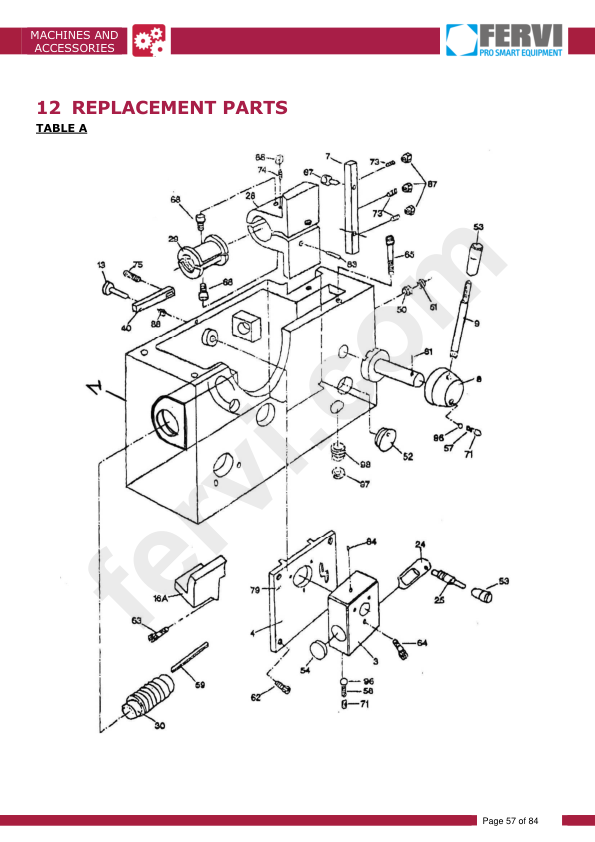


🧑: explain the parts mentioned in Table A
🤖: Based on the provided context, Table A in Section 12 of the manual is a crucial resource for identifying and assembling replacement parts for the machine. Although the specific parts listed in Table A are not visible in the segment provided, the table is designed to help users correctly identify and assemble these parts.

Here is a structured explanation of how Table A might be organized, based on typical technical manuals:

1. **Part Number**: Each component is assigned a unique identifier to facilitate ordering and reference.

2. **Description**: A brief description of each part, detailing its function or location within the machine.

3. **Quantity**: The number of each part required for a complete assembly or replacement.

4. **Material**: Information about the material composition of the part, which can be critical for understanding durability and compatibility.

5. **Illustration Reference**: A reference to the corresponding illustrati

In [77]:
ask("explain the parts mentioned in Table A")

In [79]:
ask("What is the motor power for T999/230V?")


🧑: What is the motor power for T999/230V?
🤖: The motor power for the T999/230V is 1500 W.

--- Sources ---
• table → data/tables/doc2_p010_tbl00.txt (page 10.0)
• table → data/tables/doc2_p010_tbl00.txt (page 10.0)
• table → data/tables/doc2_p010_tbl00.txt (page 10.0)
• text → data/text/doc2_p010_txt00.txt (page 10.0)
• table → data/tables/doc2_p010_tbl00.txt (page 10.0)
